In [4]:
import sys
sys.path.append('..')

from src.visualization import plot_settings
import pandas as pd
import numpy as np
import seaborn as sns

df = pd.read_csv('../data/raw/fullpilot1466.csv')
df2 = pd.read_csv('../data/raw/fullpilot13_22.csv')
df3 = pd.read_csv('../data/raw/test/spaceprl(26).csv')

df = df[df.expName.isin(['FullPilot12', 'FullPilot13', 'FullPilot14', ])]
df2 = df2[df2.expName.isin(['FullPilot12', 'FullPilot13'])]
df3 = df3[df3.expName.isin(['FullPilot12_2'])]
#concat df and df3
df = pd.concat([df, df3])

df = df.groupby('prolificID').filter(lambda x: len(x) >= 483)
df2 = df2.groupby('prolificID').filter(lambda x: len(x) >= 483)

df = pd.concat([df, df2])
# df = df.groupby('prolificID').filter(lambda x: len(x) <= 432)
# keep  prolificIDs that are more than 10 characters
df = df[df.prolificID.str.len() > 10]
# show prolificIDs

expName = ['FullPilot12_2',  'FullPilot12', 'FullPilot13', 'FullPilot14']



df['opti_ss'] = ((df.m1 > df.m2) & (df.choice==1)) | ((df.m1 < df.m2) & (df.choice==2))
df['opti_ff'] = ((df.p1 > df.p2) & (df.choice==1)) | ((df.p1 < df.p2) & (df.choice==2))
df['opti_ev'] = ((df.ev1 > df.ev2) & (df.choice==1)) | ((df.ev1 < df.ev2) & (df.choice==2))
df['chosen_p'] = np.where(df.choice == 1, df.p1, df.p2)
df['chosen_m'] = np.where(df.choice == 1, df.m1, df.m2)

df.loc[df.expName=='FullPilot14', 'destroyed'] = 1
df['outcome'] = (df.outcome1 * (df.choice == 1) * df.destroyed) + (df.outcome2 * (df.choice == 2) * df.destroyed)



df = df[df.expName.isin(expName)]
print(f'N = {len(df.prolificID.unique())}')

# remove duplicates and only take first based on prolificID, t, session
df = df.drop_duplicates(subset=['prolificID', 't', 'session'])

# replace all of the above by df
# we have m1, m2 and p1, p2, we need to say what option is riskier (higher variance) 
df['var1'] = df.p1 * (df.m1 - df.ev1)**2 + (1 - df.p1) * (0 - df.ev1)**2

df['var2'] = df.p2 * (df.m2 - df.ev2)**2 + (1 - df.p2) * (0 - df.ev2)**2
df['riskier'] = np.where(df.var1 > df.var2, 1, 2)
df['chose_safe'] = np.where(df.choice != df.riskier, 1, 0)
df['chose_risky'] = np.where(df.choice == df.riskier, 1, 0)



N = 245


In [5]:
df.columns

Index(['prolificID', 'expName', 'session', 't', 'pair', 'choice', 'outcome1',
       'outcome2', 'choseLeft', 'op1IsLeft', 'moveTime', 'fireTime',
       'leftCount', 'rightCount', 'ev1', 'ev2', 'p1', 'p2', 'm1', 'm2',
       'name1', 'name2', 'destroyed', 'score', 'datetime', 'opti_ss',
       'opti_ff', 'opti_ev', 'chosen_p', 'chosen_m', 'outcome', 'var1', 'var2',
       'riskier', 'chose_safe', 'chose_risky'],
      dtype='object')

In [19]:
df['left_best_shield'] = (((df.op1IsLeft) & (df.p1 > df.p2)) | ((~df.op1IsLeft) & (df.p2 > df.p1))).astype(int)
df['left_best_spaceship'] = (((df.op1IsLeft) & (df.m1 > df.m2)) | ((~df.op1IsLeft) & (df.m2 > df.m1))).astype(int)
df['left_best_ev'] = (((df.op1IsLeft) & (df.ev1 > df.ev2)) | ((~df.op1IsLeft) & (df.ev2 > df.ev1))).astype(int)
df['chose_left'] = (((df.choice == 1) & (df.op1IsLeft)) | ((df.choice == 2) & (~df.op1IsLeft))).astype(int)

In [25]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Fix the chose_left column creation
df_ = df[df.expName.isin(['FullPilot12'])]
# logistic regression with chose_left as DV and left_best_shield, left_best_spaceship, left_best_ev as IVs
model = smf.logit('chose_left ~ left_best_shield * left_best_spaceship', data=df_).fit()
print(model.summary())

#for each group = (perceptual, value, combined)
for name in ['perceptual', 'value', 'combined', 'random']:
    model = smf.logit('chose_left ~ left_best_shield * left_best_spaceship', data=df_[df_.group==name]).fit()
    print(f'Group: {name}')
    print(model.summary())



Optimization terminated successfully.
         Current function value: 0.632381
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:             chose_left   No. Observations:                29763
Model:                          Logit   Df Residuals:                    29759
Method:                           MLE   Df Model:                            3
Date:              lun., 13 oct. 2025   Pseudo R-squ.:                 0.08637
Time:                        17:40:49   Log-Likelihood:                -18822.
converged:                       True   LL-Null:                       -20601.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               -1.0502      0.0

In [23]:
#for each group = (perceptual, value, combined)
for name in ['perceptual', 'value', 'combined', 'random']:
    model = smf.logit('chose_left ~ left_best_shield * left_best_spaceship', data=df_[df_.group==name]).fit()
    print(f'Group: {name}')
    print(model.summary())



Optimization terminated successfully.
         Current function value: 0.585397
         Iterations 5
Group: perceptual
                           Logit Regression Results                           
Dep. Variable:             chose_left   No. Observations:                28302
Model:                          Logit   Df Residuals:                    28298
Method:                           MLE   Df Model:                            3
Date:              lun., 13 oct. 2025   Pseudo R-squ.:                  0.1554
Time:                        11:38:06   Log-Likelihood:                -16568.
converged:                       True   LL-Null:                       -19615.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                             


Rolling stats shape: (29, 4)
Trial range: 5.0 to 144.0


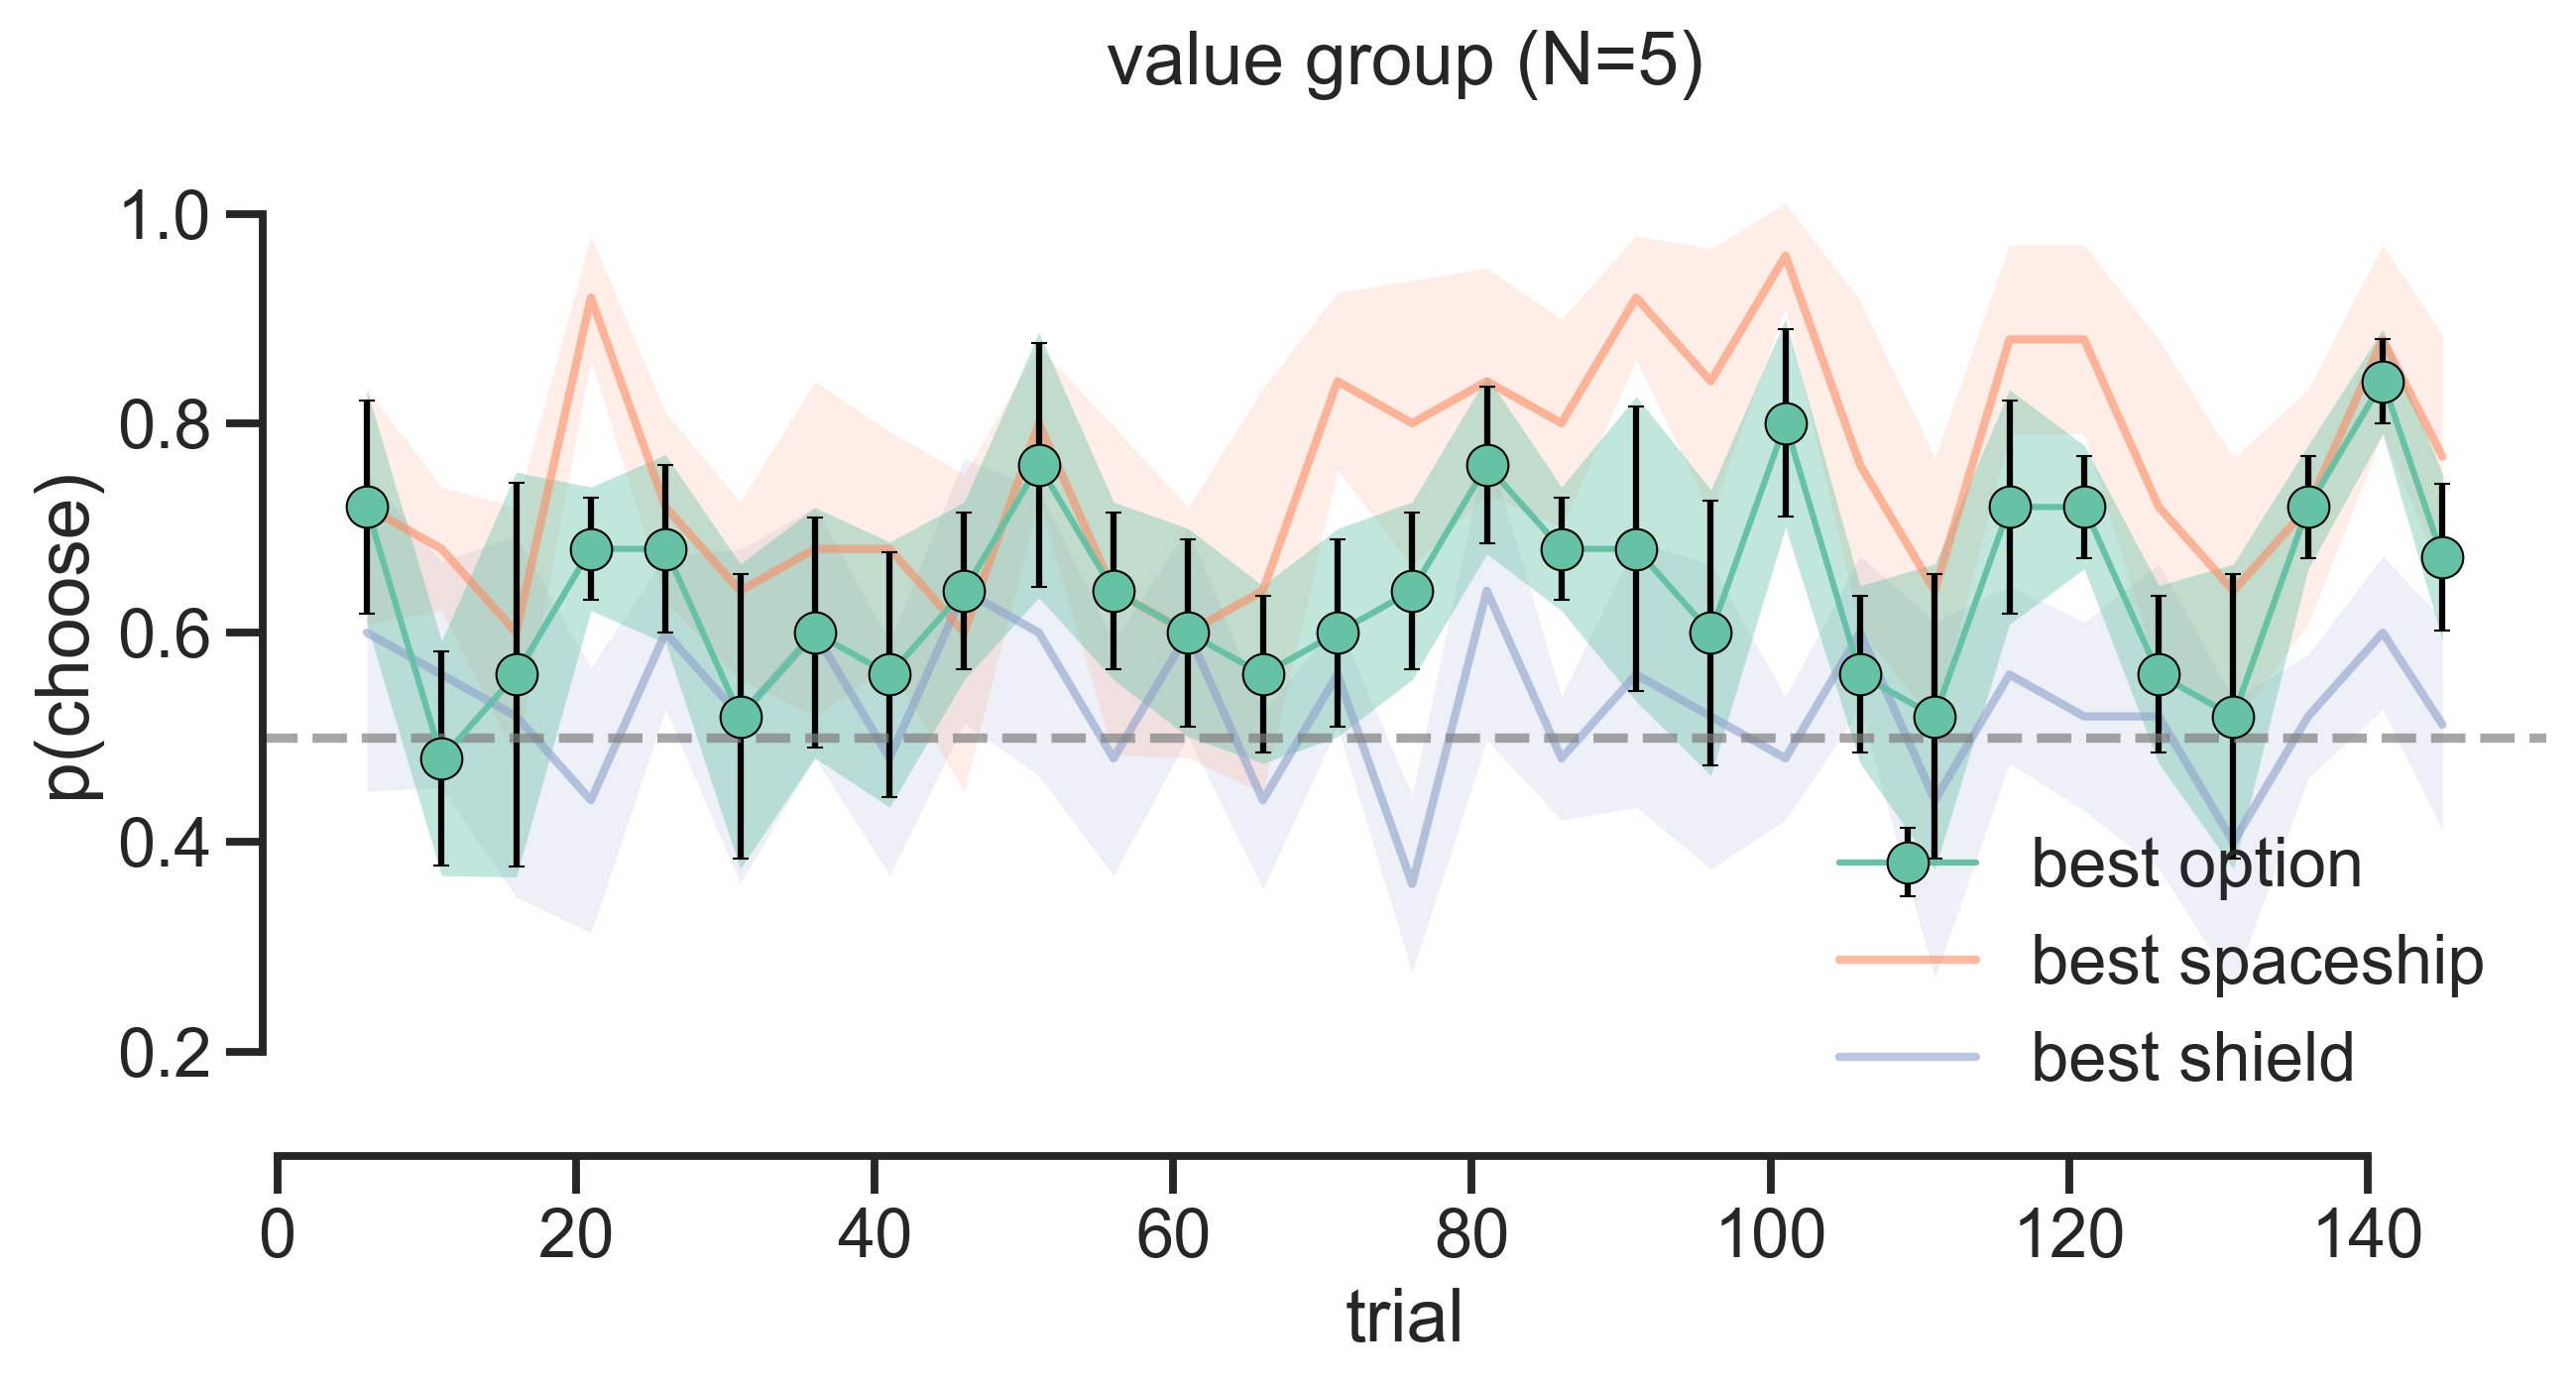

In [17]:
# Simple rolling average approach - no custom binning needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

group = 'value'
N = {'perceptual': 31, 'value': 7, 'combined': 13}
data = df[(df.expName.isin(['FullPilot12'])) & (df.session==3) & (df.pair.isin([0,1])) & (df.group!='random') & (df.group==group)].sort_values('t').copy()
data['t'] = data.groupby('prolificID').cumcount()

bin_size = 5


# Group by subject and apply rolling mean
data_rolling = data.groupby(['prolificID'])[['t', 'opti_ff', 'opti_ss', 'opti_ev']].rolling(
    window=bin_size, 
    center=True,
    min_periods=1,
).mean().reset_index()

# data_rolling2 = data[data.model=='normative'].groupby(['prolificID'])[['t', 'opti_ev']].rolling(
#     window=bin_size,
#     center=True,
#     min_periods=1,
# ).mean().reset_index()

# now add data_rolling2 to data_rolling but opti_ev is renamed to normative_model
# data_rolling = data_rolling.merge(data_rolling2[['prolificID', 't', 'opti_ev']], on=['prolificID', 't'], suffixes=('', '_normative'))   



# Select every 5th trial
stats_ff = data_rolling[data_rolling['t'] % bin_size == 0].groupby('t')['opti_ff'].agg(['mean', 'sem', 'std']).reset_index()
stats_ss = data_rolling[data_rolling['t'] % bin_size == 0].groupby('t')['opti_ss'].agg(['mean', 'sem', 'std']).reset_index()
stats_ev = data_rolling[data_rolling['t'] % bin_size == 0].groupby('t')['opti_ev'].agg(['mean', 'sem', 'std']).reset_index()
# Append the mean of the last 5 rows as trial 144
stats_ff.loc[len(stats_ff)] = [144, stats_ff.tail(5)['mean'].mean(), stats_ff.tail(5)['sem'].mean(), stats_ff.tail(5)['std'].mean()]
stats_ss.loc[len(stats_ss)] = [144, stats_ss.tail(5)['mean'].mean(), stats_ss.tail(5)['sem'].mean(), stats_ss.tail(5)['std'].mean()]
stats_ev.loc[len(stats_ev)] = [144, stats_ev.tail(5)['mean'].mean(), stats_ev.tail(5)['sem'].mean(), stats_ev.tail(5)['std'].mean()]

print(f"\nRolling stats shape: {stats_ff.shape}")
print(f"Trial range: {stats_ff['t'].min()} to {stats_ff['t'].max()}")
stats_ff['t'] = stats_ff['t'] + 1
stats_ss['t'] = stats_ss['t'] + 1
stats_ev['t'] = stats_ev['t'] + 1
# stats_normative = data_rolling[data_rolling['t'] % bin_size == 0].groupby('t')['opti_ev_normative'].agg(['mean', 'sem', 'std']).reset_index()
# Create the final plot with dots, error bars, and fill
plt.figure(figsize=(9, 5), dpi=300)
sns.set_context('talk')
# Colors for each condition
colors = {'ff': 'C2', 'ss': 'C1', 'ev': 'C0', 'normative': 'C3'}
labels = {'ff': 'best shield', 'ss': 'best spaceship', 'ev': 'best option', 'normative': 'best option (normative model)'}

# Plot each condition with different linestyles and alpha
for stats, condition in [(stats_ff, 'ff'), (stats_ss, 'ss'), (stats_ev, 'ev')]:
    color = colors[condition]
    label = labels[condition]
    
    # Set linestyle: dotted for ff and ss, solid for ev
    linestyle = '-' if condition in ['ff', 'ss', 'ev'] else ':' if condition == 'normative' else '-'
    
    # Set alpha: lower for ff and ss (0.5), normal for ev (1.0)
    alpha = .6 if condition in ['ff', 'ss'] else 1.0
    
    # Plot dots with SEM error bars and black edges
    if condition in ('ff', 'ss', 'normative'):
        color = {'ff': 'C2', 'ss': 'C1', 'normative': 'black'}[condition]
        plt.plot(stats['t'], stats['mean'], color=color, label=label, linewidth=2, linestyle=linestyle, alpha=alpha)
    else:
        plt.errorbar(stats['t'], stats['mean'], yerr=stats['sem'], 
                 fmt='o', color=color, markersize=10, capsize=2, 
                 capthick=1, label=label, linewidth=1.5, linestyle=linestyle,
                 markeredgecolor='black', markeredgewidth=0.5, ecolor='black',
                 alpha=alpha)
    
    # Add SEM fill with alpha=0.2 (even more transparent for ff and ss)
    fill_alpha = 0.15 if condition in ['ff', 'ss'] else 0.4
    
    plt.fill_between(stats['t'], 
                     stats['mean'] - stats['sem'] - 0.01, 
                     stats['mean'] + stats['sem'] + 0.01, 
                     color=color, alpha=fill_alpha, linewidth=0)

# Add horizontal reference line
plt.axhline(y=0.5, color='grey', linestyle='--', alpha=0.7)
plt.ylabel('p(choose)')
plt.xlabel('trial')

# Set x-axis ticks and y-axis limits
# plt.xticks(np.arange(0, 144, bin_size))
plt.ylim(.1, 1.1)
# plt.xticks(np.arange(5, 146, bin_size*2), np.arange(0, 145, bin_size*2))
handles, labels = plt.gca().get_legend_handles_labels()
# Add a legend
labels = labels[::-1]
# labels = [labels[1], labels[0], labels[2]]
handles = handles[::-1]
# handles = [handles[1], handles[0], handles[2]]
plt.legend(title='', loc='lower right', frameon=False, handles=handles, labels=labels)

sns.despine(trim=True)

plt.title(group + ' group (N=' + str(len(data.prolificID.unique())) + ')')

plt.tight_layout()

In [5]:

session = 3
expName = ['FullPilot12_2', 'FullPilot12']
df_ = df[(df.session==session) & (df.expName.isin(expName))].groupby(['prolificID'], as_index=False).mean(numeric_only=True)

import scipy.stats as stats

df_['delta'] = df_.opti_ff - df_.opti_ss

df_['opti_ff'] = df_.opti_ff.astype(float)
df_['opti_ss'] = df_.opti_ss.astype(float)
df_['delta'] = df_.delta.astype(float)
df['opti_ff'] = df['opti_ff'].astype(float)
df['opti_ss'] = df['opti_ss'].astype(float)
         
df2 = df[(df.session==session) & (df.expName.isin(expName))]

def get_group2(row):
    opti_ff = df2[df2.prolificID==row.prolificID].opti_ff
    opti_ss = df2[df2.prolificID==row.prolificID].opti_ss
    ttest = stats.ttest_rel(opti_ff, opti_ss)
    p = ttest.pvalue
    t = ttest.statistic
    p_ss = stats.ttest_1samp(opti_ss, 0.5, alternative='greater').pvalue < 0.05 
    p_ff = stats.ttest_1samp(opti_ff, 0.5, alternative='greater').pvalue < 0.05

    if p > 0.05:
        if p_ss and p_ff:
            return 'balanced'
        if p_ss:
            return 'value'
        if p_ff:
            return 'perceptual'
        return 'random'
    
    if t > 0 and p_ff:
        return 'perceptual'
    if t < 0  and p_ss:
        return 'value'

    return 'random'

def get_group(row):
    opti_ff = df2[df2.prolificID==row.prolificID].opti_ff
    opti_ss = df2[df2.prolificID==row.prolificID].opti_ss
    p_ss = stats.ttest_1samp(opti_ss, 0.5, alternative='greater').pvalue < 0.05 
    p_ff = stats.ttest_1samp(opti_ff, 0.5, alternative='greater').pvalue < 0.05

    if p_ss and p_ff:
        return 'combined'
        
    
    if p_ff:
        return 'perceptual'
    if p_ss:
        return 'value'

    return 'random'
    # raise ValueError('unexpected value')

df_['group'] = df_.apply(get_group, axis=1)

df['group'] = df['prolificID'].map(df_.set_index('prolificID')['group'])

# df = df[df.group != 'random']
df[df.expName.isin(expName)].groupby('prolificID').group.first().value_counts()

group
perceptual    58
combined      34
random        15
value          9
Name: count, dtype: int64

In [3]:
# load risk tests
#select prolificIDs
dd = df[(df.expName=='FullPilot12_2') & (df.session==3) & (df.pair.isin([0,1]))]
pids = dd.prolificID.unique()

# now go get these prolificIDs from the risk tests
dospert = pd.read_csv('../data/raw/test/spaceprl_dospert(5).csv')
dospert = dospert[dospert.prolificID.isin(pids)]
# general = pd.read_csv('../data/raw/test/spaceprl_general_risk(2).csv')
# general = general[general.prolificID.isin(pids)]
feed = pd.read_csv('../data/raw/test/spaceprl_feedback(1).csv')
feed = feed[feed.prolificID.isin(pids)]
lot = pd.read_csv('../data/raw/test/spaceprl_risk(4).csv')
lot = lot[lot.prolificID.isin(pids)]

# lot is a holt and laury test with 10 choices (choice_0 to choice_9)
# compute risky choices
lot['risky_choices'] = lot[[f'choice_{i}' for i in range(10)]].sum(axis=1)
# lot = lot[['prolificID', 'risky_choices', 'amount']]
# compute dospert risk score as the sum of all columns except prolificID
dospert['risk_d'] = dospert[[f'q{i}' for i in range(0, 30)]].sum(axis=1)

# compute the average of q0 to q5 if the columns exist
# first map Strongly Disagree to 1, Disagree to 2, Neutral to 3, Agree to 4, Strongly Agree to 5
feed = feed.replace({'Strongly Disagree': 5, 'Disagree': 4, 'Neutral': 3, 'Agree': 2, 'Strongly Agree': 1})
# then compute the mean of q0 to q3 if the columns exist
feed['feedback'] = feed[[f'q{i}' for i in [0,1,2,3,4]]].mean(axis=1) / 5
# for participant that have NaN in q3 and q4, take q2 value, for the reste take q3 value
# feed['feedback'] = np.where(feed.q3.isna() & feed.q2.notna(), feed.q2, feed.q3)
# for participant that have NaN in q3 and q2, take mean of q0 and q1 value, for the reste take q0 to q2 value
# feed['feedback'] = np.where(feed.q3.isna() & feed.q2.isna(), feed[[f'q{i}' for i in [0,1]]].mean(axis=1), feed[[f'q{i}' for i in [0,1,2]]].mean(axis=1))
# finally, if feedback is NaN, replace it with the mean of the feedback
# create a new df called risk 
risk = pd.merge(lot, dospert, on='prolificID', how='outer')
risk = pd.merge(risk, feed[['prolificID', 'feedback']], on='prolificID', how='outer')
# add the chose_risky avg from dd to risk
risk = pd.merge(risk, df[df.expName.isin(['FullPilot12_2']) & (df.session==3) & (df.pair.isin([0,1]))].groupby('prolificID').chose_risky.mean().reset_index(), on='prolificID', how='left')
risk = pd.merge(risk, df[df.expName.isin(['FullPilot12_2']) & (df.session==3) & (df.pair.isin([0,1]))].groupby('prolificID').chose_safe.mean().reset_index(), on='prolificID', how='left')
# also add opti_ff
risk = pd.merge(risk, df[df.expName.isin(['FullPilot12_2']) & (df.session==3) & (df.pair.isin([0,1]))].groupby('prolificID').opti_ff.mean().reset_index(), on='prolificID', how='left')
# also add opti_ss
risk = pd.merge(risk, df[df.expName.isin(['FullPilot12_2']) & (df.session==3) & (df.pair.isin([0,1]))].groupby('prolificID').opti_ss.mean().reset_index(), on='prolificID', how='left')
risk = pd.merge(risk, df[df.expName.isin(['FullPilot12_2']) & (df.session==3) & (df.pair.isin([0,1]))].groupby('prolificID').opti_ev.mean().reset_index(), on='prolificID', how='left')
# remove 65707ef834f5c6af96da98ce
risk = risk[risk.prolificID != '65707ef834f5c6af96da98ce']

risk = pd.merge(risk, df[df.expName.isin(['FullPilot12_2']) & (df.session==3) & (df.pair.isin([0,1]))].groupby('prolificID').group.first().reset_index(), on='prolificID', how='left')

df_fit = pd.read_csv('../data/processed/fit_fullpilot12_2.csv')
risk['omega'] = df_fit[df_fit.prolificID.isin(risk.prolificID)].groupby('prolificID').omega.last().reset_index(drop=True)
risk['beta'] = df_fit[df_fit.prolificID.isin(risk.prolificID)].groupby('prolificID').beta.last().reset_index(drop=True)

C:\Users\basil\AppData\Local\Temp\ipykernel_22452\1644528901.py:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feed = feed.replace({'Strongly Disagree': 5, 'Disagree': 4, 'Neutral': 3, 'Agree': 2, 'Strongly Agree': 1})


In [ ]:
# melt lot into a new df called lot_melted with columns prolificID, choice, choice_number
lot_melted = pd.melt(lot, id_vars=['prolificID'], value_vars=[f'choice_{i}' for i in range(10)], var_name='choice_number', value_name='choice')
# convert choice_number to int 
lot_melted['choice_number'] = lot_melted['choice_number'].str.replace('choice_', '').astype(int)

risk['dospert'] = risk['risk_d'] / (30 * 7)


Text(0.05, 0.8, 'r = 0.03\np = 0.827')

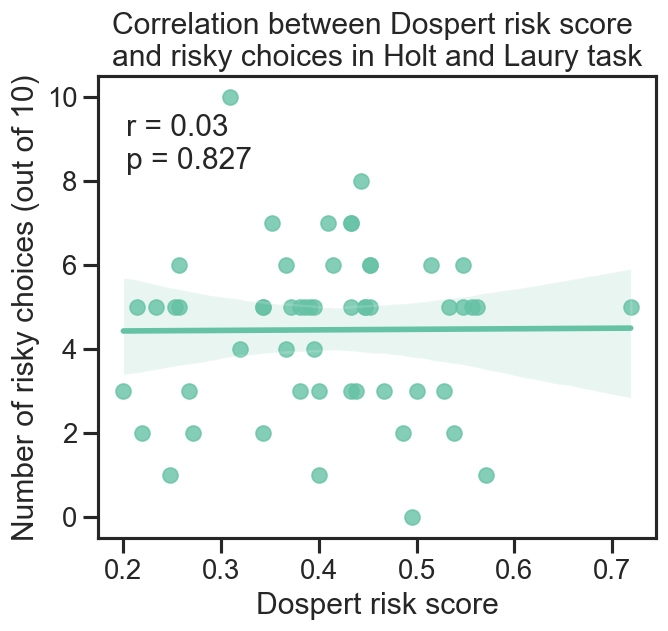

In [204]:
risk['dospert'] = risk['risk_d'] / (30 * 7)
sns.regplot(data=risk, x='dospert', y='risky_choices')

plt.xlabel('Dospert risk score')
plt.ylabel('Number of risky choices (out of 10)')
plt.title('Correlation between Dospert risk score \nand risky choices in Holt and Laury task')

# compute the spearman correlation
corr, pval = stats.spearmanr(risk['dospert'], risk['risky_choices'])
plt.annotate(f'r = {corr:.2f}\np = {pval:.3f}', xy=(0.05, 0.8), xycoords='axes fraction')

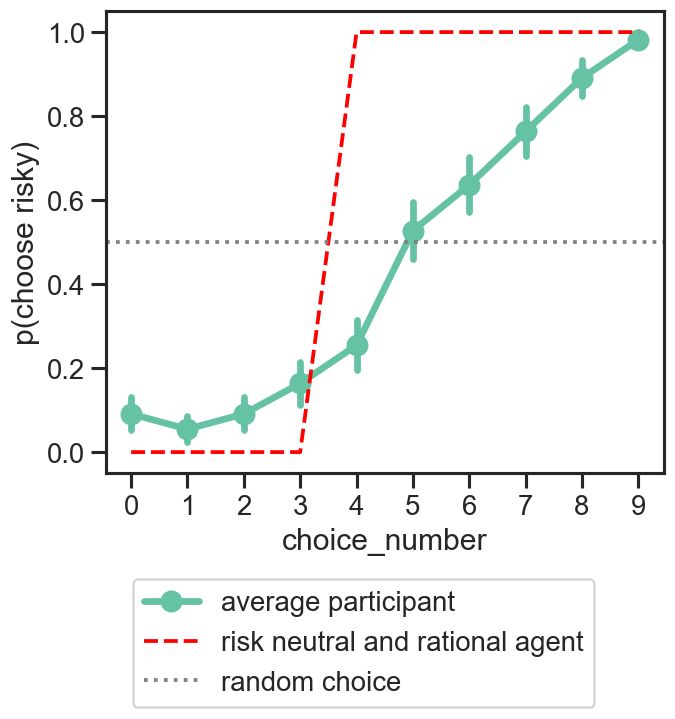

In [147]:
import matplotlib.pyplot as plt
sns.set_context('talk')
sns.pointplot(x='choice_number', y='choice', data=lot_melted, errorbar='se', label='average participant')
plt.ylabel('p(choose risky)')
# also plot rational agent in dotted line
# it is holt and laury, so the rational agent chooses risky option 6 times out of 10
rational_choices = [0, 0, 0, 0, 1, 1, 1, 1, 1,1]
plt.plot(range(10), rational_choices, linestyle='--', color='red', label='risk neutral and rational agent')
plt.axhline(0.5, linestyle=':', color='grey', label='random choice')
plt.legend(bbox_to_anchor=(0.9, -0.2))

t = -5.991023644205371, p = 1.7628414472505545e-07
***


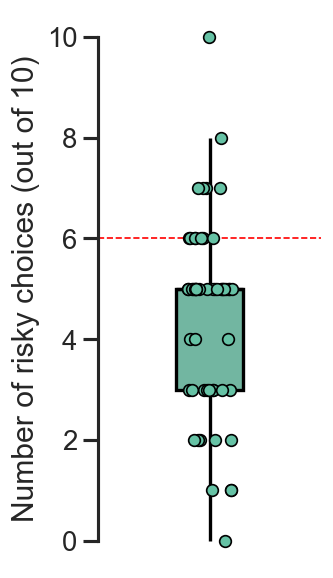

In [192]:
plt.figure(figsize=(2.4,6))
sns.set_palette('Set2')
palette = ['C2', 'C1', 'C0', 'gray']
# add group to prolificID in lot
if 'group' not in lot.columns:
    lot = pd.merge(lot, df_.set_index('prolificID')['group'], on='prolificID', how='left')
risky_choices = lot.groupby(['prolificID'], as_index=False).risky_choices.sum()
order = ['perceptual', 'value', 'combined', 'random']

sns.boxplot(data=risky_choices.risky_choices, width=0.3, linewidth=2,  color='C0', linecolor='black', whis=1.5,
             fliersize=0, showcaps=False)
sns.stripplot(data=risky_choices.risky_choices, size=7, edgecolor='black',
              linewidth=1, color='C0')
plt.ylabel('Number of risky choices (out of 10)')
plt.xticks([])
plt.xticks(rotation=45, length=10)

# plt.ylim(0, 1)

# 0.5 dotted line
plt.axhline(6, color='red', linestyle='--', linewidth=1, label='risk neutral agent')
plt.legend().remove()

# test if the mean of risk_d/(30*7) is significantly different from 0.5
import scipy.stats as stats
t, p = stats.ttest_1samp(risky_choices.risky_choices, 6)
print(f't = {t}, p = {p}')
# print also stars based on p value
if p < 0.001:
    print('***')
elif p < 0.01:
    print('**')
elif p < 0.05:
    print('*')  

sns.despine(trim=True, bottom=True)

# plt.legend()

# from statannotations.Annotator import Annotator
# pairs = [
#     ('perceptual', 'value'),
#     ('perceptual', 'combined'),
#     ('value', 'combined'),
#     ('perceptual', 'random'),
#     ('value', 'random'),
#     ('combined', 'random'),
# ]

# annot = Annotator(plt.gca(), pairs, data=risky_choices, x='group', y='risky_choices', order=order)
# annot.configure(test='t-test_ind', text_format='star', loc='outside', verbose=2)
# annot.apply_and_annotate()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

perceptual vs. value: t-test independent samples, P_val:7.258e-01 t=3.539e-01
value vs. combined: t-test independent samples, P_val:8.549e-01 t=-1.853e-01
combined vs. random: t-test independent samples, P_val:5.414e-01 t=6.213e-01
perceptual vs. combined: t-test independent samples, P_val:7.223e-01 t=3.576e-01
value vs. random: t-test independent samples, P_val:7.682e-01 t=3.064e-01
perceptual vs. random: t-test independent samples, P_val:4.359e-01 t=7.891e-01


C:\Users\garciaba\AppData\Local\Temp\ipykernel_25752\1740382734.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='group', y='risky_choices', boxprops=dict(alpha=0.5), fliersize=0, width=0.3, linewidth=2, data=risky_choices,  order=order, palette=palette)
C:\Users\garciaba\AppData\Local\Temp\ipykernel_25752\1740382734.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='group', y='risky_choices' , color='C0', size=7, edgecolor='black', linewidth=1, data=risky_choices, order=order, palette=palette)


(<Axes: xlabel='group', ylabel='Number of risky choices (out of 10)'>,
  <statannotations.Annotation.Annotation at 0x1fad81f06d0>])

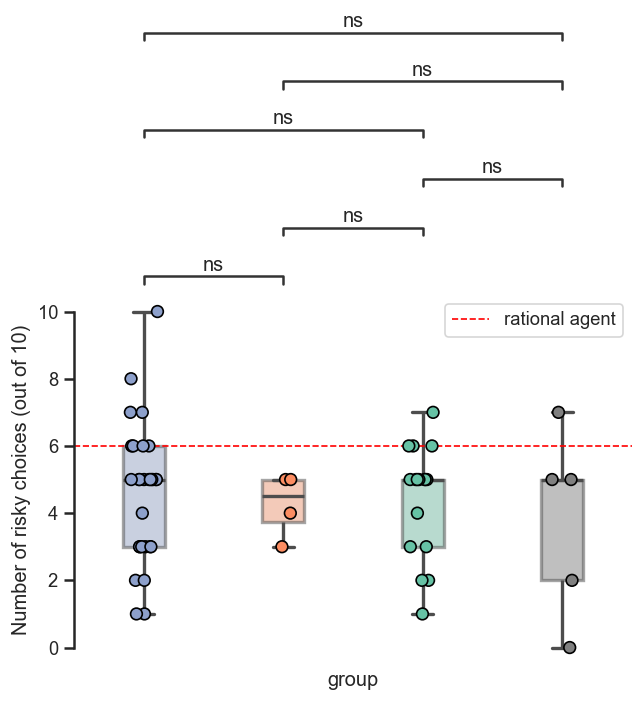

In [111]:
plt.figure(figsize=(6,4))
sns.set_palette('Set2')
palette = ['C2', 'C1', 'C0', 'gray']
# add group to prolificID in lot
if 'group' not in lot.columns:
    lot = pd.merge(lot, df_.set_index('prolificID')['group'], on='prolificID', how='left')
risky_choices = lot.groupby(['prolificID','group'], as_index=False).risky_choices.sum()
order = ['perceptual', 'value', 'combined', 'random']
sns.boxplot(x='group', y='risky_choices', boxprops=dict(alpha=0.5), fliersize=0, width=0.3, linewidth=2, data=risky_choices,  order=order, palette=palette)
sns.stripplot(x='group', y='risky_choices' , color='C0', size=7, edgecolor='black', linewidth=1, data=risky_choices, order=order, palette=palette)

plt.ylabel('Number of risky choices (out of 10)')
plt.xticks([])
plt.xticks(rotation=45, length=10)

# plt.ylim(0, 1)

# 0.5 dotted line
plt.axhline(6, color='red', linestyle='--', linewidth=1, label='rational agent')
plt.legend()

# test if the mean of risk_d/(30*7) is significantly different from 0.5
# import scipy.stats as stats
# t, p = stats.ttest_1samp(risky_choices, 5)
# print(f't = {t}, p = {p}')
# # print also stars based on p value
# if p < 0.001:
#     print('***')
# elif p < 0.01:
#     print('**')
# elif p < 0.05:
#     print('*')  

sns.despine(trim=True, bottom=True)

# plt.legend()

from statannotations.Annotator import Annotator
pairs = [
    ('perceptual', 'value'),
    ('perceptual', 'combined'),
    ('value', 'combined'),
    ('perceptual', 'random'),
    ('value', 'random'),
    ('combined', 'random'),
]

annot = Annotator(plt.gca(), pairs, data=risky_choices, x='group', y='risky_choices', order=order)
annot.configure(test='t-test_ind', text_format='star', loc='outside', verbose=2)
annot.apply_and_annotate()

t = -5.991023644205371, p = 1.7628414472505545e-07
***


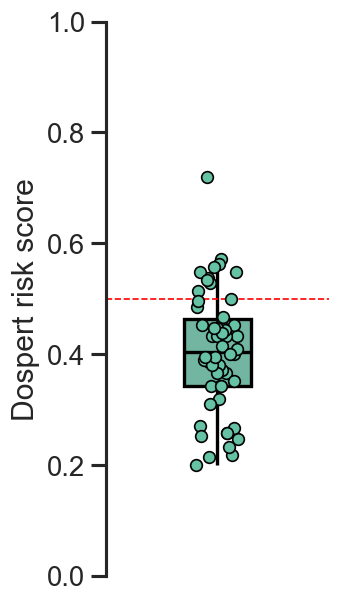

In [197]:
plt.figure(figsize=(2.4,6))
sns.set_palette('Set2')
palette = ['C2', 'C1', 'C0', 'gray']
riskk = risk.copy()
riskk = riskk.groupby(['prolificID','group'], as_index=False).risk_d.sum()
riskk['risk_d'] = riskk['risk_d'] / (30 * 7)
order = ['perceptual', 'value', 'combined', 'random']

sns.boxplot(data=riskk.risk_d, width=0.3, linewidth=2,  color='C0', linecolor='black', whis=1.5,
             fliersize=0, showcaps=False)
sns.stripplot(data=riskk.risk_d, size=7, edgecolor='black',
              linewidth=1, color='C0')
plt.ylabel('Dospert risk score')
plt.xticks([])
plt.xticks(rotation=45, length=10)

plt.ylim(0, 1)

# 0.5 dotted line
plt.axhline(0.5, color='red', linestyle='--', linewidth=1, label='risk neutral agent')
plt.legend().remove()

# test if the mean of risk_d/(30*7) is significantly different from 0.5
import scipy.stats as stats
t, p = stats.ttest_1samp(risky_choices.risky_choices, 6)
print(f't = {t}, p = {p}')
# print also stars based on p value
if p < 0.001:
    print('***')
elif p < 0.01:
    print('**')
elif p < 0.05:
    print('*')  

sns.despine(trim=True, bottom=True)

# plt.legend()

# from statannotations.Annotator import Annotator
# pairs = [
#     ('perceptual', 'value'),
#     ('perceptual', 'combined'),
#     ('value', 'combined'),
#     ('perceptual', 'random'),
#     ('value', 'random'),
#     ('combined', 'random'),
# ]

# annot = Annotator(plt.gca(), pairs, data=risky_choices, x='group', y='risky_choices', order=order)
# annot.configure(test='t-test_ind', text_format='star', loc='outside', verbose=2)
# annot.apply_and_annotate()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

perceptual vs. value: t-test independent samples, P_val:7.186e-01 t=3.638e-01
value vs. combined: t-test independent samples, P_val:6.436e-01 t=-4.701e-01
combined vs. random: t-test independent samples, P_val:3.649e-01 t=9.271e-01
perceptual vs. combined: t-test independent samples, P_val:6.817e-01 t=-4.129e-01
value vs. random: t-test independent samples, P_val:7.679e-01 t=3.068e-01
perceptual vs. random: t-test independent samples, P_val:3.651e-01 t=9.192e-01


C:\Users\garciaba\AppData\Local\Temp\ipykernel_25752\3124057789.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='group', y='risk_d', boxprops=dict(alpha=0.5), fliersize=0, width=0.3, linewidth=2, data=riskk,  order=order, palette=palette)
C:\Users\garciaba\AppData\Local\Temp\ipykernel_25752\3124057789.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='group', y='risk_d' , color='C0', size=7, edgecolor='black', linewidth=1, data=riskk, order=order, palette=palette)


(<Axes: xlabel='group', ylabel='Number of risky choices (out of 10)'>,
  <statannotations.Annotation.Annotation at 0x1fad66908e0>])

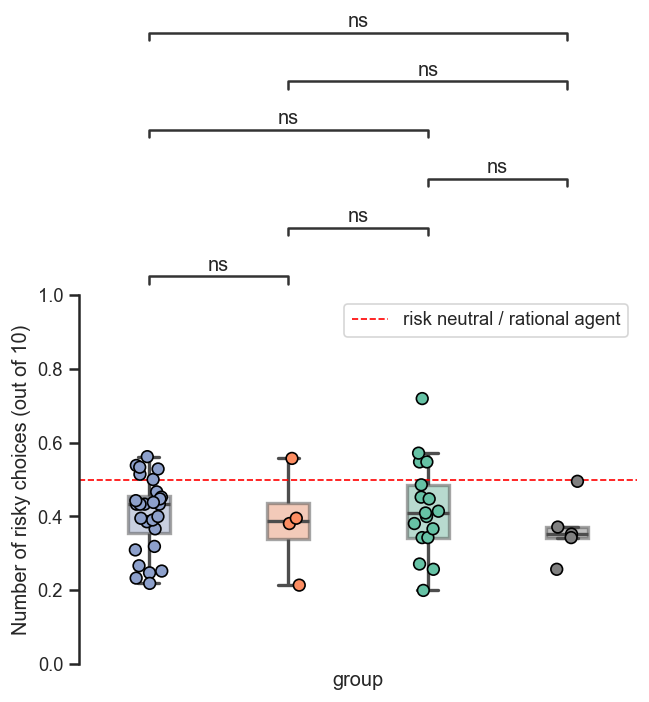

In [120]:
plt.figure(figsize=(6,4))
sns.set_palette('Set2')
palette = ['C2', 'C1', 'C0', 'gray']
# add group to prolificID in lot

riskk = risk.copy()
riskk = riskk.groupby(['prolificID','group'], as_index=False).risk_d.sum()
riskk['risk_d'] = riskk['risk_d'] / (30 * 7)
order = ['perceptual', 'value', 'combined', 'random']
sns.boxplot(x='group', y='risk_d', boxprops=dict(alpha=0.5), fliersize=0, width=0.3, linewidth=2, data=riskk,  order=order, palette=palette)
sns.stripplot(x='group', y='risk_d' , color='C0', size=7, edgecolor='black', linewidth=1, data=riskk, order=order, palette=palette)

plt.ylabel('Number of risky choices (out of 10)')
plt.xticks([])
plt.xticks(rotation=45, length=10)

plt.ylim(0, 1)

# 0.5 dotted line
plt.axhline(.5, color='red', linestyle='--', linewidth=1, label='risk neutral / rational agent')
plt.legend()

# test if the mean of risk_d/(30*7) is significantly different from 0.5
# import scipy.stats as stats
# t, p = stats.ttest_1samp(risky_choices, 5)
# print(f't = {t}, p = {p}')
# # print also stars based on p value
# if p < 0.001:
#     print('***')
# elif p < 0.01:
#     print('**')
# elif p < 0.05:
#     print('*')  

sns.despine(trim=True, bottom=True)

# plt.legend()

from statannotations.Annotator import Annotator
pairs = [
    ('perceptual', 'value'),
    ('perceptual', 'combined'),
    ('value', 'combined'),
    ('perceptual', 'random'),
    ('value', 'random'),
    ('combined', 'random'),
]

annot = Annotator(plt.gca(), pairs, data=riskk, x='group', y='risk_d', order=order)
annot.configure(test='t-test_ind', text_format='star', loc='outside', verbose=2)
annot.apply_and_annotate()

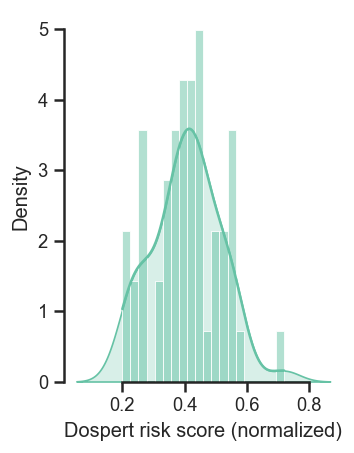

In [67]:
plt.figure(figsize=(3,4))

sns.kdeplot(risk.risk_d/(30*7), fill=True)
sns.histplot(risk.risk_d/(30*7), stat='density', bins=20, color='C0', kde=True)
plt.xlabel('Dospert risk score (normalized)')
sns.despine(trim=True)

t = -6.352275559029455, p = 4.9563046332156856e-08
***


Text(0.5, 1.0, 'Control conditions only')

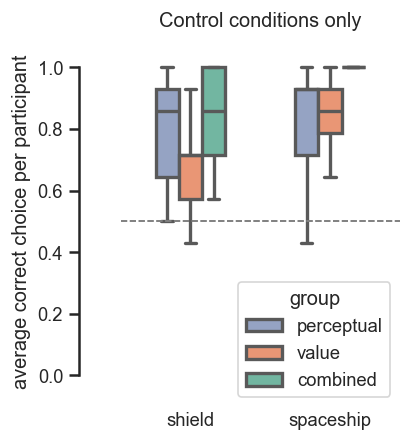

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(3,4))
control_ff = df[(df.expName.isin(['FullPilot12'])) & 
                (df.session==3) & (df.pair.isin([-1])) & (df.group!='random')].groupby('prolificID').opti_ff.mean().reset_index()
control_ss = df[(df.expName.isin(['FullPilot12'])) &
                (df.session==3) & (df.pair.isin([-2])) & (df.group!='random')].groupby('prolificID').opti_ss.mean().reset_index()

new_df = pd.DataFrame(
    {'prolificID': control_ff.prolificID,
     'type': ['opti_ff'] * len(control_ff) + ['opti_ss'] * len(control_ss),
     'opti': pd.concat([control_ff.opti_ff, control_ss.opti_ss], ignore_index=True),
     'group': pd.concat([control_ff.prolificID.map(df_.set_index('prolificID')['group']), control_ss.prolificID.map(df_.set_index('prolificID')['group'])], ignore_index=True)

    }
)

order = ['opti_ff', 'opti_ss']
sns.boxplot(x='type', y='opti', data=new_df, hue='group', palette=['C2', 'C1', 'C0'], hue_order=['perceptual', 'value', 'combined'],
           fliersize=0, width=0.5, linewidth=2, order=order)

# Add stripplot with offset to the right side
# sns.stripplot(x='type', y='opti', data=new_df, color='C0', jitter=0.1, size=7, 
#               edgecolor='black', linewidth=1, order=order, hue='group', palette=['C0', 'C2', 'C1'],
#               dodge=2, native_scale=True)

plt.xticks([])
plt.xticks(rotation=45, length=10)  

plt.ylim(-.1, 1.1)

# 0.5 dotted line
plt.axhline(0.5, color='gray', linestyle='--', linewidth=1)

# test if the mean of risk_d/(30*7) is significantly different from 0.5
import scipy.stats as stats
t, p = stats.ttest_1samp(risk.risk_d/(30*7), 0.5)
print(f't = {t}, p = {p}')
# print also stars based on p value
if p < 0.001:
    print('***')
elif p < 0.01:
    print('**')
elif p < 0.05:
    print('*')  

sns.despine(trim=True, bottom=True)
plt.xticks([0, 1], ['shield', 'spaceship'])
plt.tick_params(axis='x', length=0)
plt.ylim(-.1, 1.1)
plt.xlabel('')
plt.ylabel('average correct choice per participant')
plt.axhline(0.5, color='gray', linestyle='--', linewidth=1)
sns.despine(trim=True, bottom=True, offset=25)
plt.title('Control conditions only')


In [ ]:
df

C:\Users\basil\AppData\Local\Temp\ipykernel_22452\765136948.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='type', y='opti', data=new_df, palette=['C2', 'C1'],


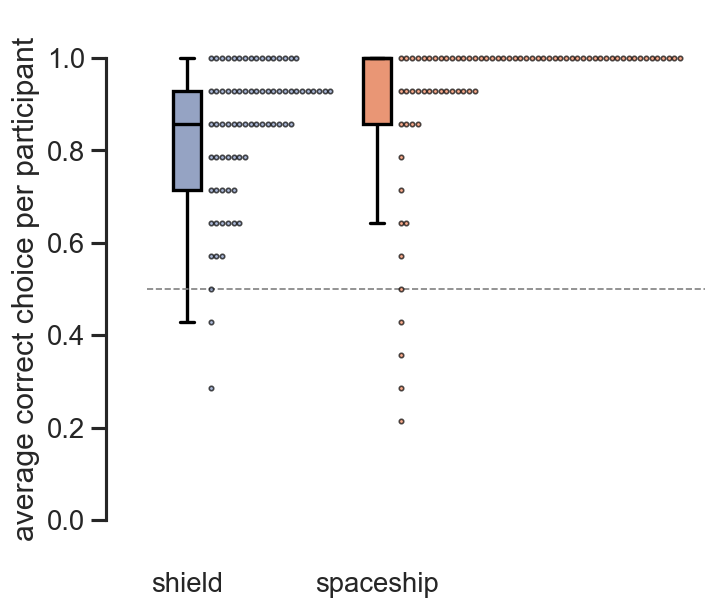

In [23]:
from scipy.stats import gaussian_kde

import matplotlib.pyplot as plt
def violin_scatter(x_pos, y_values, width=0.3, n_bins=20, dot_spacing=0.02):
    """
    Arrange scatter points in a violin/KDE shape, left-aligned from x_pos.
    Points start at x_pos with FIXED equal spacing between dots.
    
    Parameters:
    -----------
    x_pos : float
        The x-position (left edge) for this group
    y_values : array-like
        The y-values to plot
    width : float
        Maximum width of the violin shape (not used, kept for compatibility)
    n_bins : int
        Number of bins for density estimation
    dot_spacing : float
        Fixed horizontal spacing between dots
        
    Returns:
    --------
    x_coords, y_coords : arrays
        Coordinates for plotting
    """
    y_values = np.array(y_values)
    
    # Estimate density using KDE
    kde = gaussian_kde(y_values, bw_method='scott')
    
    # Create bins
    y_range = np.linspace(y_values.min(), y_values.max(), n_bins)
    
    # Assign each point to a bin
    bin_indices = np.digitize(y_values, y_range)
    
    x_coords = []
    y_coords = []
    
    for bin_idx in range(1, n_bins + 1):
        # Get points in this bin
        mask = bin_indices == bin_idx
        bin_points = y_values[mask]
        n_points = len(bin_points)
        
        if n_points == 0:
            continue
            
        # Get density at bin center for determining how many points to show
        if bin_idx <= len(y_range):
            bin_center = y_range[bin_idx - 1]
        else:
            bin_center = y_range[-1]
            
        density = kde(bin_center)[0]
        
        # Calculate number of dots to show based on density
        # Scale by density but use FIXED spacing
        max_density = kde(y_range).max()
        n_dots_to_show = int(np.ceil(n_points * density / max_density))
        n_dots_to_show = min(n_dots_to_show, n_points)  # Don't exceed available points
        
        # FIXED EQUAL SPACING: each dot moves by exactly dot_spacing
        x_offsets = [i * dot_spacing for i in range(n_dots_to_show)]
            
        x_coords.extend([x_pos + offset for offset in x_offsets])
        y_coords.extend(bin_points[:n_dots_to_show])  # Take first n_dots_to_show points
    
    return np.array(x_coords), np.array(y_coords)


# Example usage
plt.figure(figsize=(6,6))
sns.set_context('talk')
exps = ['FullPilot12', 'FullPilot12_2']
control_ff = df[(df.expName.isin(exps)) & 
                (df.session==3) & (df.pair.isin([-1])) & (df.group!='random')].groupby('prolificID').opti_ff.mean().reset_index()
control_ss = df[(df.expName.isin(exps)) &
                (df.session==3) & (df.pair.isin([-2])) & (df.group!='random')].groupby('prolificID').opti_ss.mean().reset_index()

new_df = pd.DataFrame(
    {'prolificID': control_ff.prolificID,
     'type': ['opti_ff'] * len(control_ff) + ['opti_ss'] * len(control_ss),
     'opti': pd.concat([control_ff.opti_ff, control_ss.opti_ss], ignore_index=True)}
)

order = ['opti_ff', 'opti_ss']
box_width = 0.15

# Create boxplot
sns.boxplot(x='type', y='opti', data=new_df, palette=['C2', 'C1'], 
            linecolor='black', fliersize=0, width=box_width, linewidth=2, 
            order=order, zorder=1)

# Add violin-shaped scatter starting from right edge of boxplot
colors = ['C2', 'C1']
for i, (type_val, color) in enumerate(zip(order, colors)):
    y_vals = new_df[new_df.type == type_val].opti.values
    # Start from right edge of box (i + box_width/2)
    x_coords, y_coords = violin_scatter(i + box_width/2 + 0.05, y_vals, 
                                        width=1, n_bins=40, dot_spacing=0.03)
    
    plt.scatter(x_coords, y_coords, s=7, color=color, 
                edgecolor='black', linewidth=1, alpha=0.7, zorder=3)

plt.xticks([0, 1], ['shield', 'spaceship'])
plt.tick_params(axis='x', length=0)
plt.ylim(-.1, 1.1)
plt.xlabel('')
plt.ylabel('average correct choice per participant')
plt.axhline(0.5, color='gray', linestyle='--', linewidth=1)
sns.despine(trim=True, bottom=True, offset=25)
# plt.title('Control conditions only')


In [124]:
control_ss.opti_ss.unique()

array([1.        , 0.71428571, 0.85714286, 0.92857143, 0.78571429,
       0.57142857, 0.64285714, 0.42857143])

C:\Users\garciaba\AppData\Local\Temp\ipykernel_36756\188568601.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='type', y='opti', data=new_df, palette=['C2', 'C1'],
C:\Users\garciaba\AppData\Local\Temp\ipykernel_36756\188568601.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(x='type', y='opti', data=new_df, palette=['C2', 'C1'],


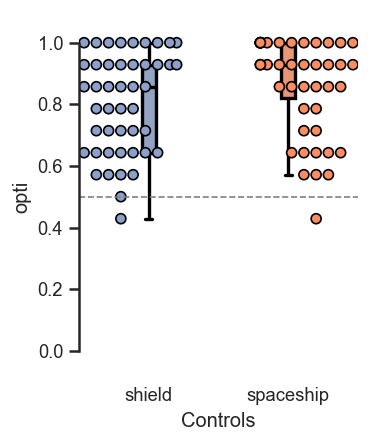

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(3,4))

control_ff = df[(df.expName.isin(['FullPilot12'])) & 
                (df.session==3) & (df.pair.isin([-1])) & (df.group!='random')].groupby('prolificID').opti_ff.mean().reset_index()
control_ss = df[(df.expName.isin(['FullPilot12'])) &
                (df.session==3) & (df.pair.isin([-2])) & (df.group!='random')].groupby('prolificID').opti_ss.mean().reset_index()

new_df = pd.DataFrame(
    {'prolificID': control_ff.prolificID,
     'type': ['opti_ff'] * len(control_ff) + ['opti_ss'] * len(control_ss),
     'opti': pd.concat([control_ff.opti_ff, control_ss.opti_ss], ignore_index=True)}
)

order = ['opti_ff', 'opti_ss']
box_width = 0.1
dodge_distance = 1.5  # Controls separation from boxplot

# Create boxplot
sns.boxplot(x='type', y='opti', data=new_df, palette=['C2', 'C1'], 
            linecolor='black', fliersize=0, width=box_width, linewidth=2, 
            order=order, zorder=1)

# Add swarmplot with controlled positioning
sns.swarmplot(x='type', y='opti', data=new_df, palette=['C2', 'C1'],
              size=6, edgecolor='black', linewidth=1, order=order,
              dodge=True, warn_thresh=0.8,  # Adjust warn_thresh to control overlap tolerance
              zorder=2)

# Manually offset swarmplot if needed
ax = plt.gca()
for collection in ax.collections[2:]:  # Skip boxplot artists (first 2 collections)
    offsets = collection.get_offsets()
    offsets[:, 0] += dodge_distance  # Shift right
    collection.set_offsets(offsets)

plt.xticks([0, 1], ['shield', 'spaceship'])
plt.tick_params(axis='x', length=0)
plt.xlabel('Controls')
plt.ylim(-.1, 1.1)
plt.axhline(0.5, color='gray', linestyle='--', linewidth=1)
sns.despine(trim=True, bottom=True)

t = -6.352275559029455, p = 4.9563046332156856e-08
***


C:\Users\garciaba\AppData\Local\Temp\ipykernel_36756\113223989.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='type', y='opti', data=new_df, palette=['C2', 'C1'], linecolor='black',
C:\Users\garciaba\AppData\Local\Temp\ipykernel_36756\113223989.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='type', y='opti', data=new_df, palette=['C2', 'C1'],  size=6, edgecolor='black',


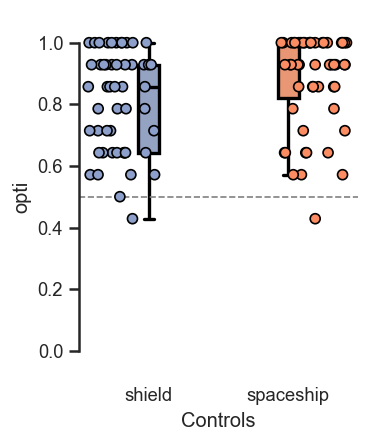

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(3,4))
control_ff = df[(df.expName.isin(['FullPilot12'])) & 
                (df.session==3) & (df.pair.isin([-1])) & (df.group!='random')].groupby('prolificID').opti_ff.mean().reset_index()
control_ss = df[(df.expName.isin(['FullPilot12'])) &
                (df.session==3) & (df.pair.isin([-2])) & (df.group!='random')].groupby('prolificID').opti_ss.mean().reset_index()

new_df = pd.DataFrame(
    {'prolificID': control_ff.prolificID,
     'type': ['opti_ff'] * len(control_ff) + ['opti_ss'] * len(control_ss),
     'opti': pd.concat([control_ff.opti_ff, control_ss.opti_ss], ignore_index=True),
     'group': pd.concat([control_ff.prolificID.map(df_.set_index('prolificID')['group']), control_ss.prolificID.map(df_.set_index('prolificID')['group'])], ignore_index=True)

    }
)

order = ['opti_ff', 'opti_ss']
sns.boxplot(x='type', y='opti', data=new_df, palette=['C2', 'C1'], linecolor='black',
            # boxprops=dict(alpha=0.5),
             fliersize=0, width=0.15, linewidth=2, order=order)

# Add stripplot with offset to the right side
sns.stripplot(x='type', y='opti', data=new_df, palette=['C2', 'C1'],  size=6, edgecolor='black',
              linewidth=1, order=order, jitter=.5,
              dodge=True, native_scale=True)

plt.xticks([0, 1], ['shield', 'spaceship'])
# remove tick length for x axis
plt.tick_params(axis='x', length=0)
plt.xlabel('Controls')
plt.ylim(-.1, 1.1)

# 0.5 dotted line
plt.axhline(0.5, color='gray', linestyle='--', linewidth=1)

# test if the mean of risk_d/(30*7) is significantly different from 0.5
import scipy.stats as stats
t, p = stats.ttest_1samp(risk.risk_d/(30*7), 0.5)
print(f't = {t}, p = {p}')
# print also stars based on p value
if p < 0.001:
    print('***')
elif p < 0.01:
    print('**')
elif p < 0.05:
    print('*')  

sns.despine(trim=True, bottom=True)

C:\Users\garciaba\AppData\Local\Temp\ipykernel_36756\3007484320.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='type', y='opti', data=new_df, boxprops=dict(alpha=0.5), fliersize=0, width=0.3, linewidth=2, order=order, palette=['C2', 'C1'])


t = -6.352275559029455, p = 4.9563046332156856e-08
***


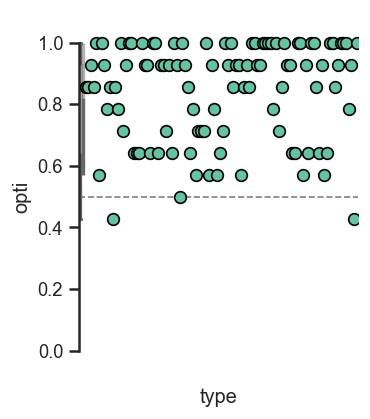

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(3,4))
control_ff = df[(df.expName.isin(['FullPilot12'])) & 
                (df.session==3) & (df.pair.isin([-1])) & (df.group!='random')].groupby('prolificID').opti_ff.mean().reset_index()
control_ss = df[(df.expName.isin(['FullPilot12'])) &
                (df.session==3) & (df.pair.isin([-2])) & (df.group!='random')].groupby('prolificID').opti_ss.mean().reset_index()

new_df = pd.DataFrame(
    {'prolificID': control_ff.prolificID,
     'type': ['opti_ff'] * len(control_ff) + ['opti_ss'] * len(control_ss),
     'opti': pd.concat([control_ff.opti_ff, control_ss.opti_ss], ignore_index=True)}
)

order = ['opti_ff', 'opti_ss']
sns.boxplot(x='type', y='opti', data=new_df, boxprops=dict(alpha=0.5), fliersize=0, width=0.3, linewidth=2, order=order, palette=['C2', 'C1'])
# sns.stripplot(x='type', y='opti', data=new_df, color='C0',  jitter=0.05, size=7, edgecolor='black', linewidth=1, order=order, palette=['C2', 'C1'])
#plot a stripplot on the right side of the boxplot
# plt.ylabel('DOSPERT risk score (normalized)')
plt.xticks([])
plt.xticks(rotation=45, length=10)  

plt.ylim(-.1, 1.1)

# 0.5 dotted line
plt.axhline(0.5, color='gray', linestyle='--', linewidth=1)

# test if the mean of risk_d/(30*7) is significantly different from 0.5
import scipy.stats as stats
t, p = stats.ttest_1samp(risk.risk_d/(30*7), 0.5)
print(f't = {t}, p = {p}')
# print also stars based on p value
if p < 0.001:
    print('***')
elif p < 0.01:
    print('**')
elif p < 0.05:
    print('*')  

sns.despine(trim=True, bottom=True)

t = -6.352275559029455, p = 4.9563046332156856e-08
***


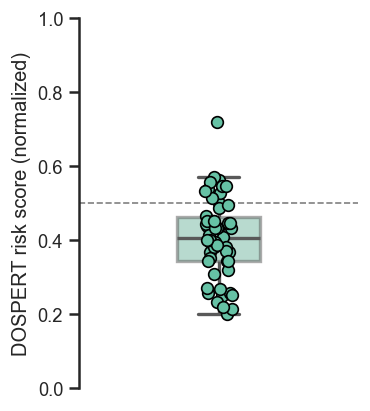

In [69]:
plt.figure(figsize=(3,4))
sns.boxplot(y=risk.risk_d/(30*7), boxprops=dict(alpha=0.5), fliersize=0, width=0.3, linewidth=2)
sns.stripplot(y=risk.risk_d/(30*7), color='C0',  jitter=0.05, size=7, edgecolor='black', linewidth=1)

plt.ylabel('DOSPERT risk score (normalized)')
plt.xticks([])
plt.xticks(rotation=45, length=10)

plt.ylim(0, 1)

# 0.5 dotted line
plt.axhline(0.5, color='gray', linestyle='--', linewidth=1)

# test if the mean of risk_d/(30*7) is significantly different from 0.5
import scipy.stats as stats
t, p = stats.ttest_1samp(risk.risk_d/(30*7), 0.5)
print(f't = {t}, p = {p}')
# print also stars based on p value
if p < 0.001:
    print('***')
elif p < 0.01:
    print('**')
elif p < 0.05:
    print('*')  

sns.despine(trim=True, bottom=True)

In [103]:
import scipy.stats as stats
stats.pearsonr(df_fit.omega, df_fit.beta)

PearsonRResult(statistic=-0.16798812856402606, pvalue=0.22021657611283635)

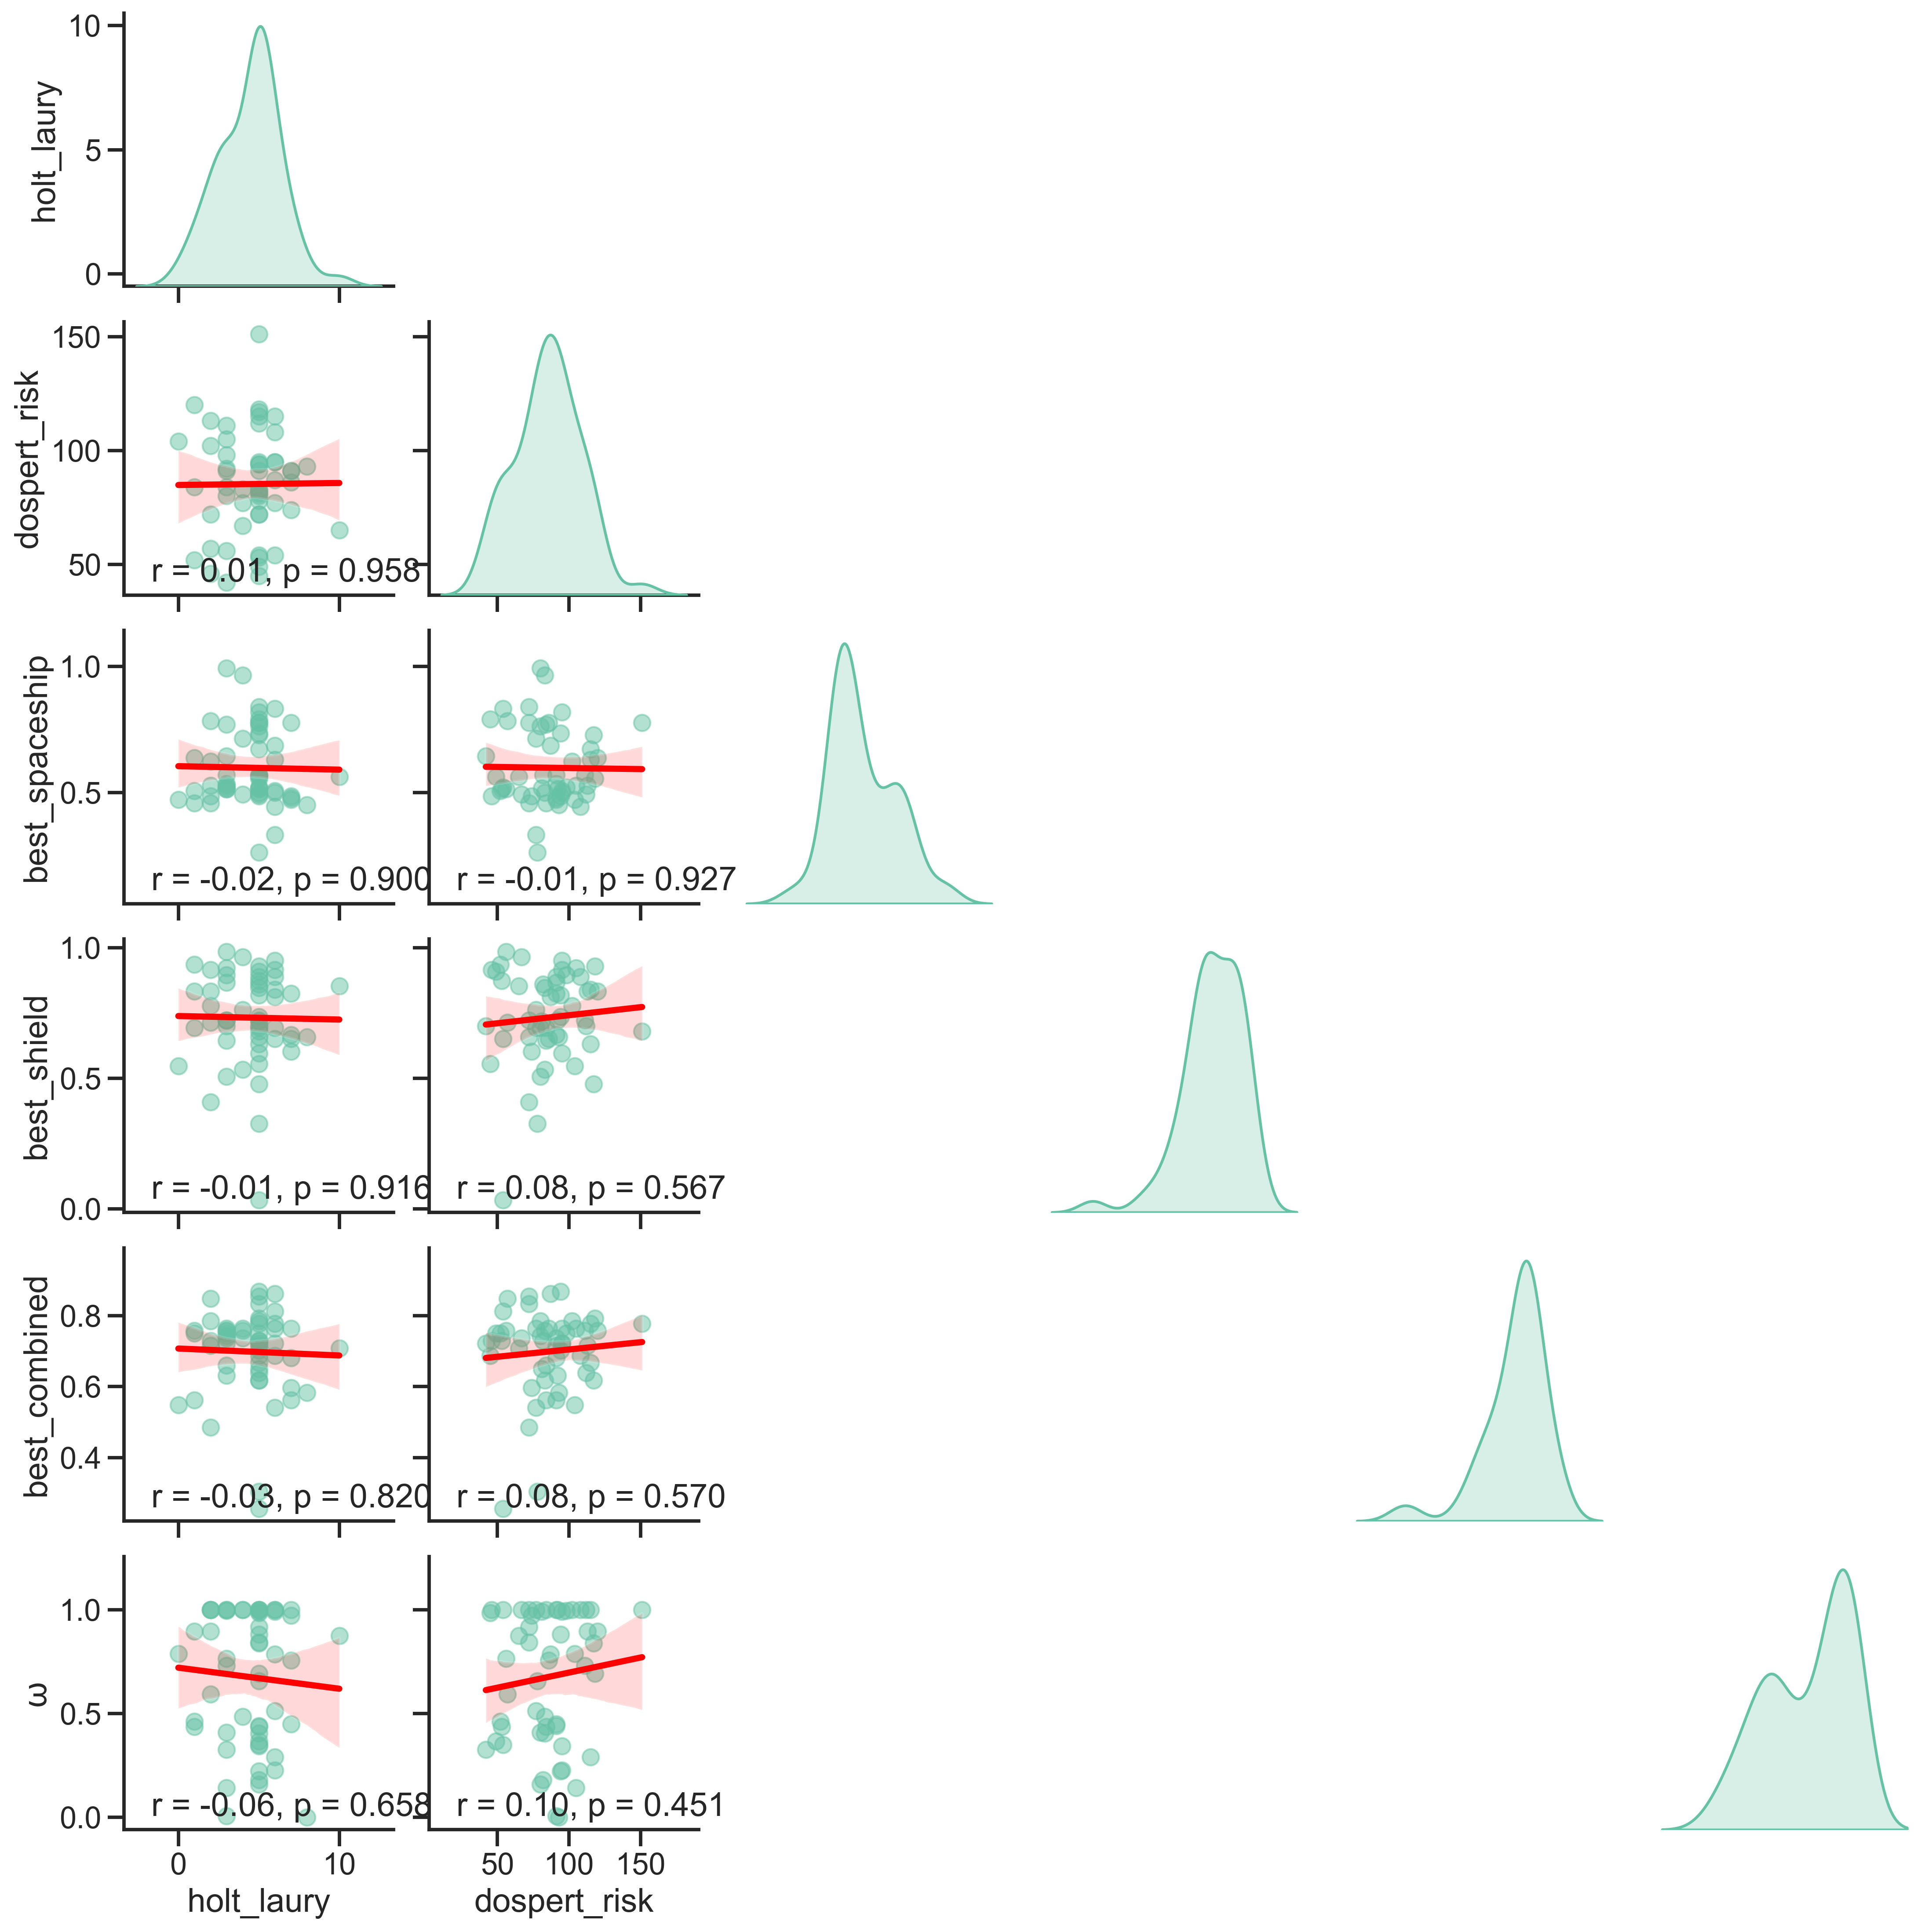

In [210]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('Set2')
# do big regplot of all risk measures against chose_risky

#rename risky_choices in holt_laury
risk = risk.rename(columns={'risky_choices': 'holt_laury'})
#rename risk_q to general_risk
# risk = risk.rename(columns={'risk_q': 'general_risk'})
risk = risk.rename(columns={'risk_d': 'dospert_risk'})
risk = risk.rename(columns={'opti_ff': 'best_shield'})
# rename opti_ss to best spaceship
risk = risk.rename(columns={'opti_ss': 'best_spaceship'})
risk = risk.rename(columns={'opti_ev': 'best_combined'})
risk = risk.rename(columns={'chose_risky': 'chose_risky'})

risk = risk.rename(columns={'feedback': 'feedback=hard'})
# set beta to symbol
# symbol = β 
risk = risk.rename(columns={'beta': 'β'})
# set omega to symbol   
# symbol = ω
risk = risk.rename(columns={'omega': 'ω'})
variables = ['holt_laury', 'dospert_risk', 'best_spaceship', 'best_shield', 'best_combined', 'ω']
# rename opti_ff to best shield


# we want regression lines for each plot and the correlation coefficient
# show correlation coefficients
import scipy.stats as stats
def corrfunc(x, y, **kws):
    r, p = stats.pearsonr(x, y)
    # test also with spearman
    # r, p = stats.spearmanr(x, y)
    ax = plt.gca()
    # add stars
    if p < 0.001:
        stars = '***'
    elif p < 0.01:
        stars = '**'
    elif p < 0.05:
        stars = '*'
    else:
        stars = ''
    ax.annotate(f'{stars}', xy=(.1, .85), xycoords=ax.transAxes, color='blue')
    ax.annotate(f'r = {r:.2f}, p = {p:.3f}', xy=(.1, .05), xycoords=ax.transAxes)

sns.set({'figure.figsize': (18, 10), 'figure.dpi': 300})
sns.set_style('ticks')
sns.set_context('talk')
sns.set_palette('Set2')

# we don't want to see after the diagonal, i.e we want to mask the upper triangle
h = sns.pairplot(risk[variables], kind='reg', diag_kind='kde', 
plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha':0.5}}).map_lower(corrfunc)

#remove upper triangle
for i, j in zip(*np.triu_indices_from(h.axes, 1)):
    h.axes[i, j].set_visible(False)

# remove column 2 to 5
for i in (2, 3, 4, 5):
    for j in range(6):
        h.axes[j, i].set_visible(False)
  

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 [Text(0.5, 0, 'holt_laury'),
  Text(1.5, 0, 'dospert_risk'),
  Text(2.5, 0, 'chose_risky'),
  Text(3.5, 0, 'feedback=hard'),
  Text(4.5, 0, 'best_spaceship'),
  Text(5.5, 0, 'best_shield'),
  Text(6.5, 0, 'best_combined'),
  Text(7.5, 0, 'ω'),
  Text(8.5, 0, 'β')])

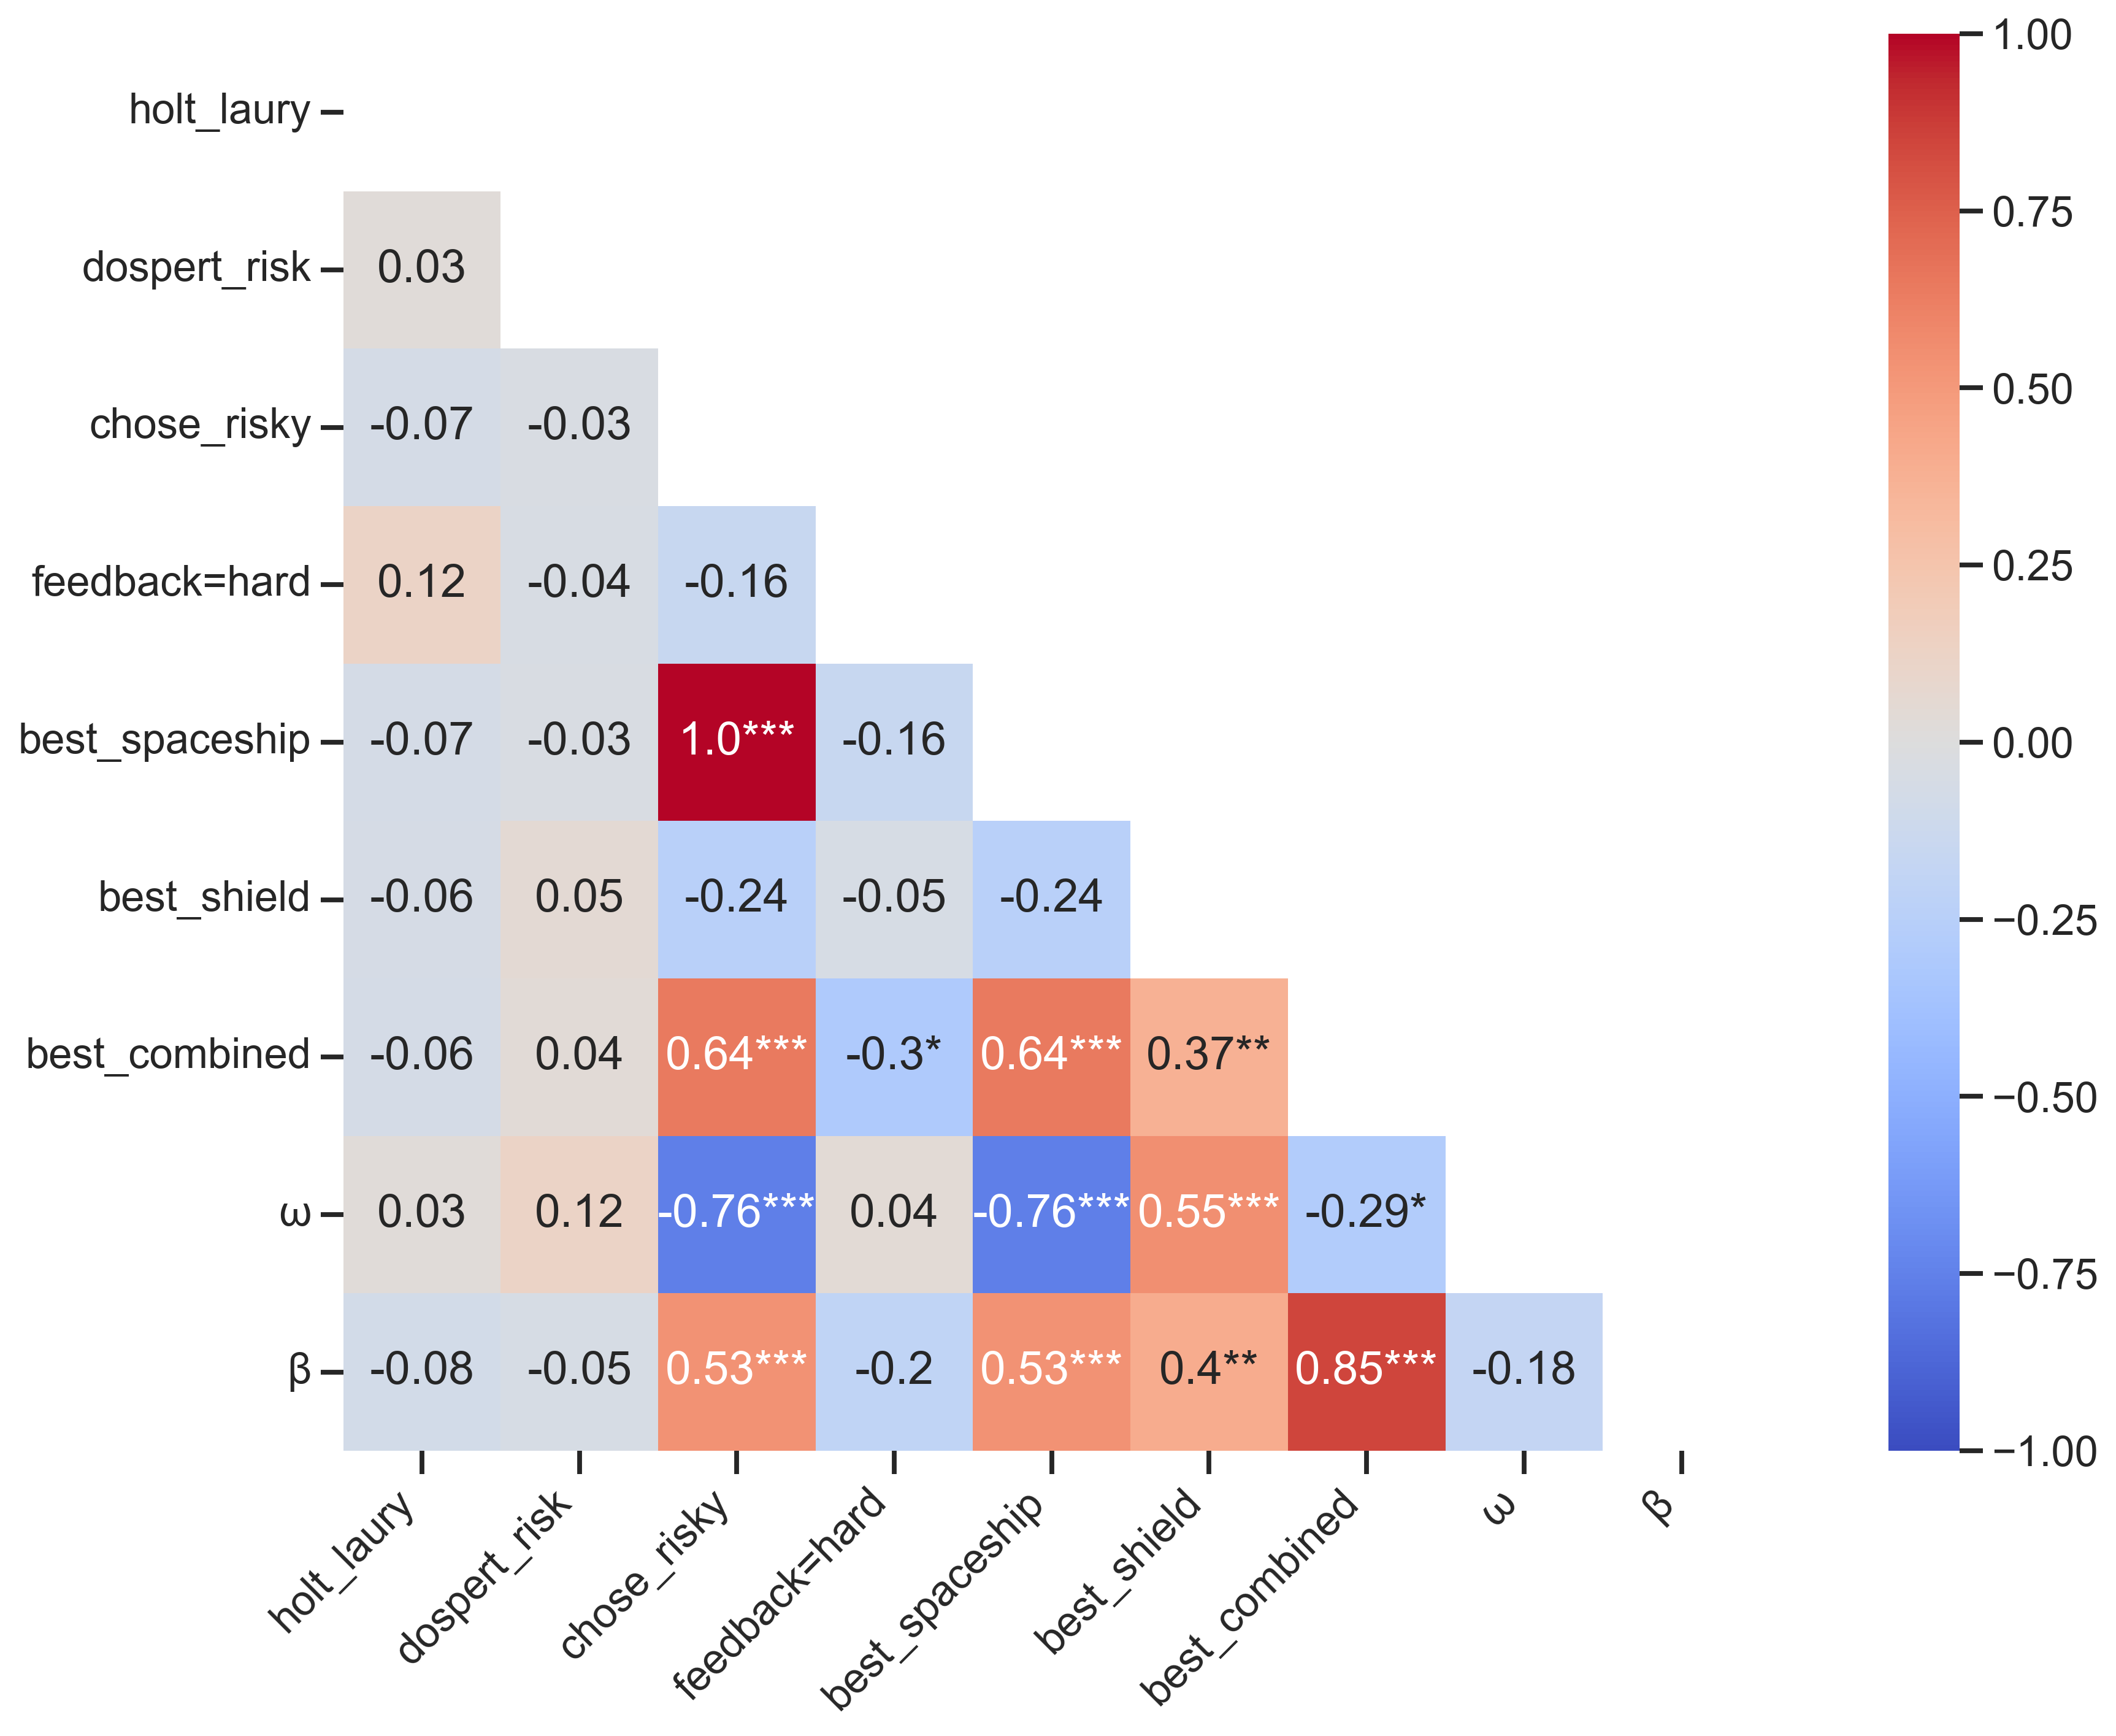

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('Set2')
# do big regplot of all risk measures against chose_risky

#rename risky_choices in holt_laury
risk = risk.rename(columns={'risky_choices': 'holt_laury'})
#rename risk_q to general_risk
# risk = risk.rename(columns={'risk_q': 'general_risk'})
risk = risk.rename(columns={'risk_d': 'dospert_risk'})
risk = risk.rename(columns={'opti_ff': 'best_shield'})
# rename opti_ss to best spaceship
risk = risk.rename(columns={'opti_ss': 'best_spaceship'})
risk = risk.rename(columns={'opti_ev': 'best_combined'})
risk = risk.rename(columns={'chose_risky': 'chose_risky'})

risk = risk.rename(columns={'feedback': 'feedback=hard'})
# set beta to symbol
# symbol = β 
risk = risk.rename(columns={'beta': 'β'})
# set omega to symbol   
# symbol = ω
risk = risk.rename(columns={'omega': 'ω'})
variables = ['holt_laury', 'dospert_risk', 'chose_risky', 'feedback=hard', 'best_spaceship', 'best_shield', 'best_combined', 'ω', 'β']
# rename opti_ff to best shield


# we want regression lines for each plot and the correlation coefficient
# show correlation coefficients
import scipy.stats as stats
def corrfunc(x, y, **kws):
    # r, p = stats.pearsonr(x, y)
    # test also with spearman
    r, p = stats.spearmanr(x, y)
    ax = plt.gca()
    # add stars
    if p < 0.001:
        stars = '***'
    elif p < 0.01:
        stars = '**'
    elif p < 0.05:
        stars = '*'
    else:
        stars = ''
    ax.annotate(f'{stars}', xy=(.1, .85), xycoords=ax.transAxes, color='blue')
    ax.annotate(f'r = {r:.2f}, p = {p:.3f}', xy=(.1, .05), xycoords=ax.transAxes)

sns.set({'figure.figsize': (18, 10), 'figure.dpi': 300})
sns.set_style('ticks')
sns.set_context('talk')
sns.set_palette('Set2')

riskk = risk[variables].copy()
# Compute correlation and p-values
corr = pd.DataFrame(np.zeros((riskk.shape[1], riskk.shape[1])), columns=riskk.columns, index=riskk.columns)
pvals = pd.DataFrame(np.zeros((riskk.shape[1], riskk.shape[1])), columns=riskk.columns, index=riskk.columns)

for col1 in riskk.columns:
    for col2 in riskk.columns:
        r, p = stats.spearmanr(riskk[col1], riskk[col2])
        corr.loc[col1, col2] = r
        pvals.loc[col1, col2] = p

# Function to map p-values to stars
def significance_stars(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""

# Build annotation matrix
annot = corr.round(2).astype(str)
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        annot.iloc[i, j] = annot.iloc[i, j] + significance_stars(pvals.iloc[i, j])


# sns.heatmap(corr.astype(float), annot=annot, 
#             cmap='coolwarm', vmin=-1, vmax=1, mask=np.triu(np.ones_like(risk[variables].corr(), dtype=bool)))
sns.heatmap(corr.astype(float), annot=annot, fmt="", cmap="coolwarm", center=0, vmin=-1, vmax=1, square=True, mask=np.triu(np.ones_like(corr, dtype=bool)))
# we need to add the stars for significance
# perhaps we should use
plt.xticks(rotation=45, ha='right')

r = -0.17008052344287536, p = 0.2188585894294


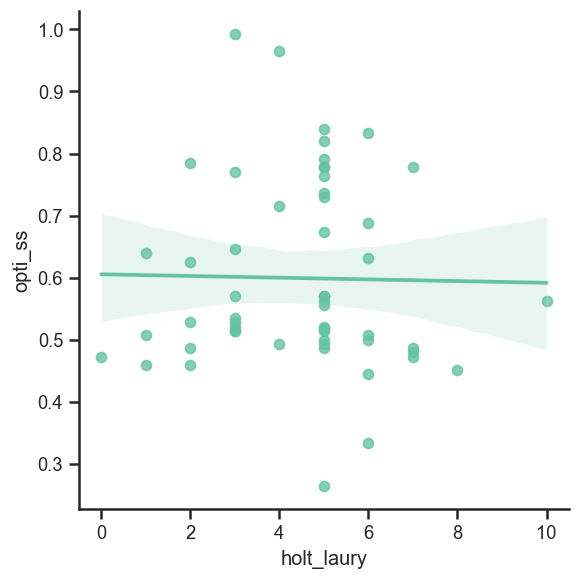

In [14]:

sns.lmplot(x='holt_laury', y='opti_ss', data=risk)
# correlation
import scipy.stats as stats
r, p = stats.pearsonr(risk.feedback, risk.opti_ss)
print(f'r = {r}, p = {p}')

In [42]:
import statsmodels.api as sm
# mnlogit to predict group from holt_laury

# Ensure group is categorical and holt_laury is numeric
risk['group'] = risk['group'].astype('category')
risk['holt_laury'] = pd.to_numeric(risk['holt_laury'], errors='coerce')

# Convert group to numeric codes for MNLogit
risk['group_code'] = risk['group'].cat.codes

model = sm.MNLogit.from_formula('group_code ~ holt_laury', data=risk).fit()
# print(model.summary())

# do I have to use MNLogit or can I use OLS?
model = sm.OLS.from_formula('opti_ss ~  feedback', data=risk).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 1.109903
         Iterations 6
                             OLS Regression Results                            
Dep. Variable:                 opti_ss   R-squared:                       0.029
Model:                             OLS   Adj. R-squared:                  0.010
Method:                  Least Squares   F-statistic:                     1.549
Date:              mar., 30 sept. 2025   Prob (F-statistic):              0.219
Time:                         14:16:47   Log-Likelihood:                 26.559
No. Observations:                   54   AIC:                            -49.12
Df Residuals:                       52   BIC:                            -45.14
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------

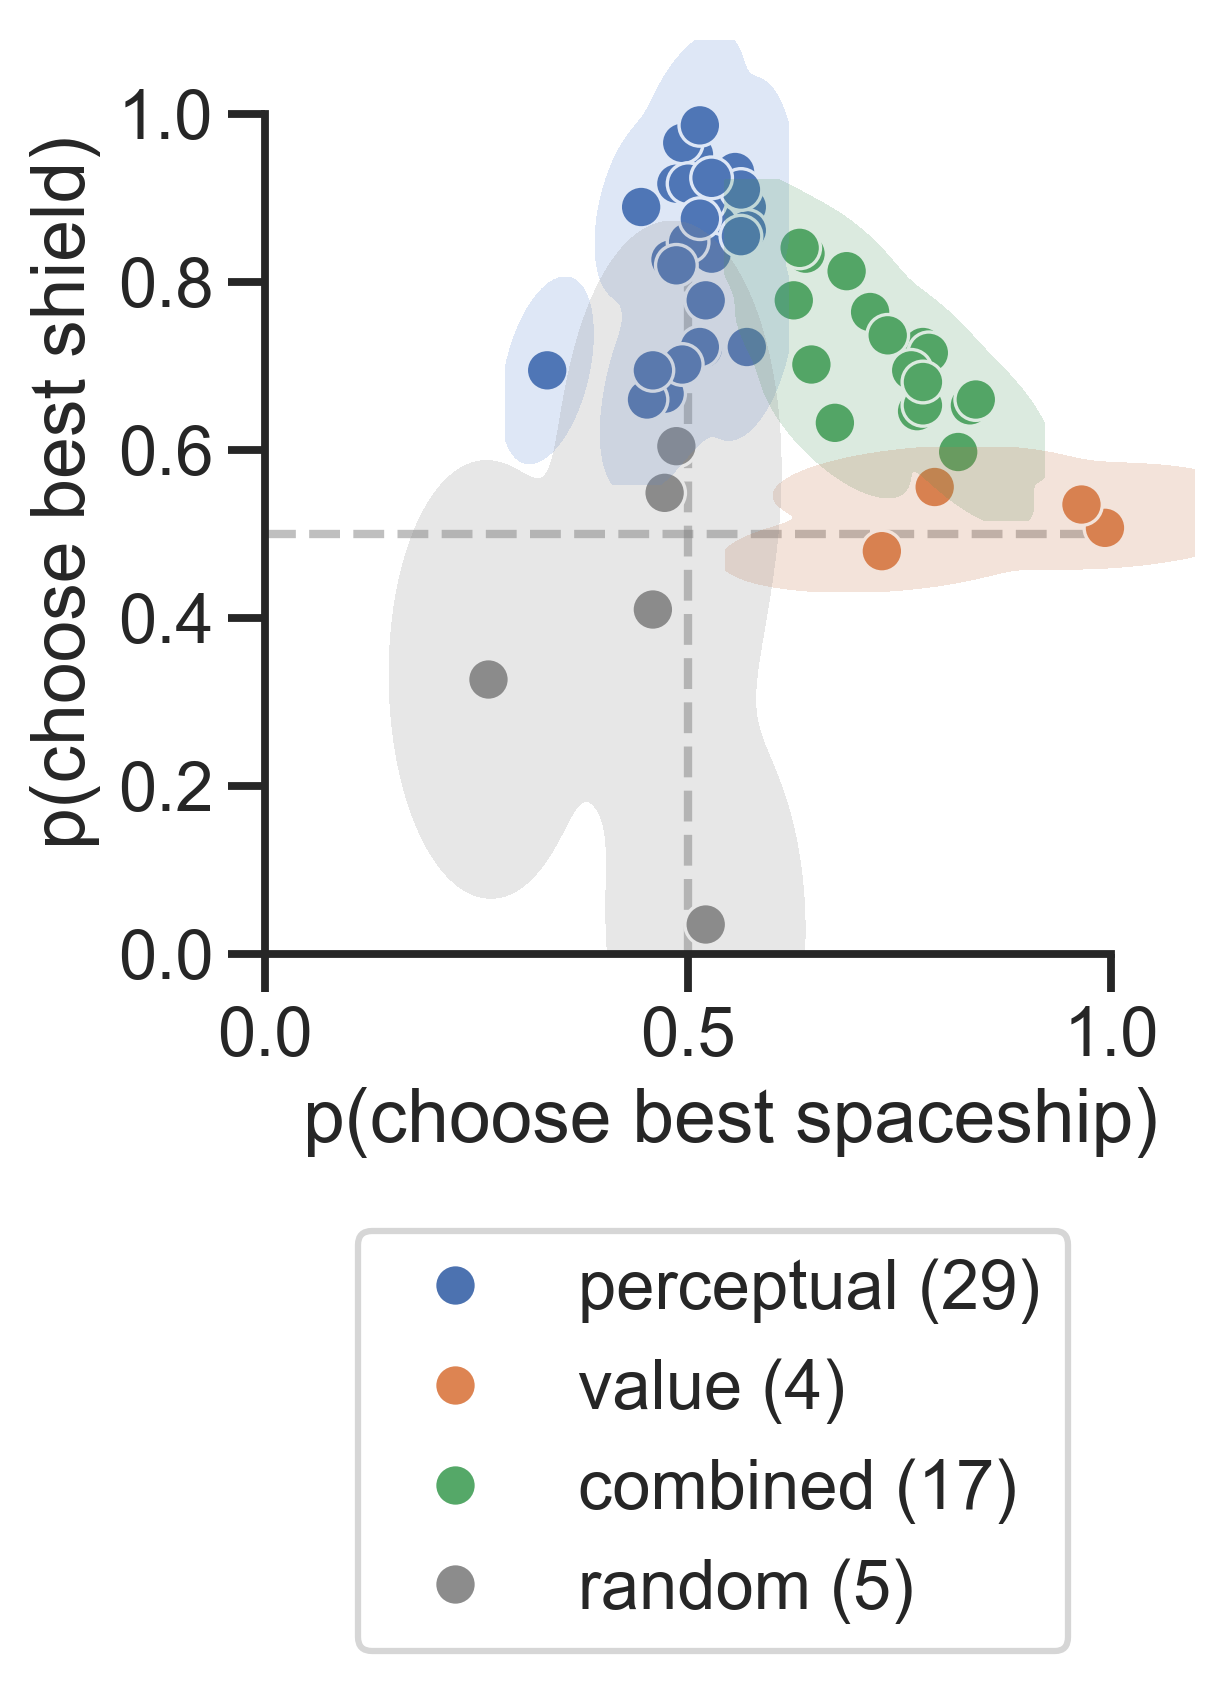

In [56]:
# same but with scatterplot

import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
exp = 'FullPilot12_2'
df_ = df[(df.session==3) & (df.pair.isin([0,1])) & (df.expName==exp)].groupby(['prolificID', 'group'], as_index=False).mean(numeric_only=True)
# df_ = df_[df_.group!='random']
sns.set(rc={'figure.figsize':(4,4), 'figure.dpi': 300})
sns.set_context("talk")
sns.set_style("ticks")


# sort by group 
order = ['perceptual', 'combined', 'value', 'random']
df_['group'] = pd.Categorical(df_['group'], categories=order, ordered=True)

# df_['opti_ss_training'] = df[(df.expName=='FullPilot14') & (df.session==2) & (df.group!='random')].groupby(['prolificID', 'group']).opti_ss.mean().values
# df_['opti_ff_training'] = df[(df.expName=='FullPilot14') & (df.session==1) & (df.group!='random')].groupby(['prolificID', 'group']).opti_ff.mean().values

scatter = sns.scatterplot(data=df_, x='opti_ss', y='opti_ff', hue='group', palette=['C0', 'C2', 'C1', 'C7'], s=100)


# using seaborn, we want a region of interest using the colors of the clusters in scatterplot
sns.kdeplot(data=df_, x='opti_ss', y='opti_ff', alpha=0.2, fill=True, palette=['C0', 'C2', 'C1', 'C7'], hue='group',
             levels=2, bw_adjust=0.6, thresh=0.001) 
# Draw kdeplot for clusters with sufficient points


# add a third dimension (opti_ev)
plt.ylim(0.0, 1.1)
plt.xlim(0.0, 1.1)



plt.plot([0, 1], [.5, .5], color='grey', lw=2, ls='--', alpha=0.5, zorder=-100)
plt.plot([.5, .5], [0, 1], color='grey', lw=2, ls='--', alpha=0.5, zorder=-100)

plt.xlabel('p(choose best spaceship)')
plt.ylabel('p(choose best shield)')
# put legend outside
# N = len(data)
# plt.title(f'counterfactual+R/2; N={N}')
sns.despine(trim=True)
#no legend
# plt.legend().remove()

#
# use order for legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = ['perceptual', 'value', 'combined', 'random']
handles = [handles[order.index(label)] for label in labels]
labels = [f'{label} ({len(df_[df_.group==label])})' for label in labels]
plt.legend(title='', bbox_to_anchor=(0.1, -.3), labels=labels, handles=handles,
           loc=2, borderaxespad=0.)

# legend order
# plt.legend().remove()

In [28]:
df_[df_.group=='random'].opti_ff, df_[df_.group=='random'].opti_ss

(5     0.326389
 15    0.604167
 40    0.409722
 50    0.034722
 54    0.548611
 Name: opti_ff, dtype: float64,
 5     0.263889
 15    0.486111
 40    0.458333
 50    0.520833
 54    0.472222
 Name: opti_ss, dtype: float64)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

opti_ss_FullPilot12_2 vs. opti_ss_FullPilot12: t-test independent samples, P_val:4.443e-01 t=7.676e-01
opti_ff_FullPilot12_2 vs. opti_ff_FullPilot12: t-test independent samples, P_val:4.572e-01 t=7.459e-01
opti_ev_FullPilot12_2 vs. opti_ev_FullPilot12: t-test independent samples, P_val:1.442e-01 t=1.470e+00


(<Axes: ylabel='p(choose best)'>,
  <statannotations.Annotation.Annotation at 0x1860b23edc0>])

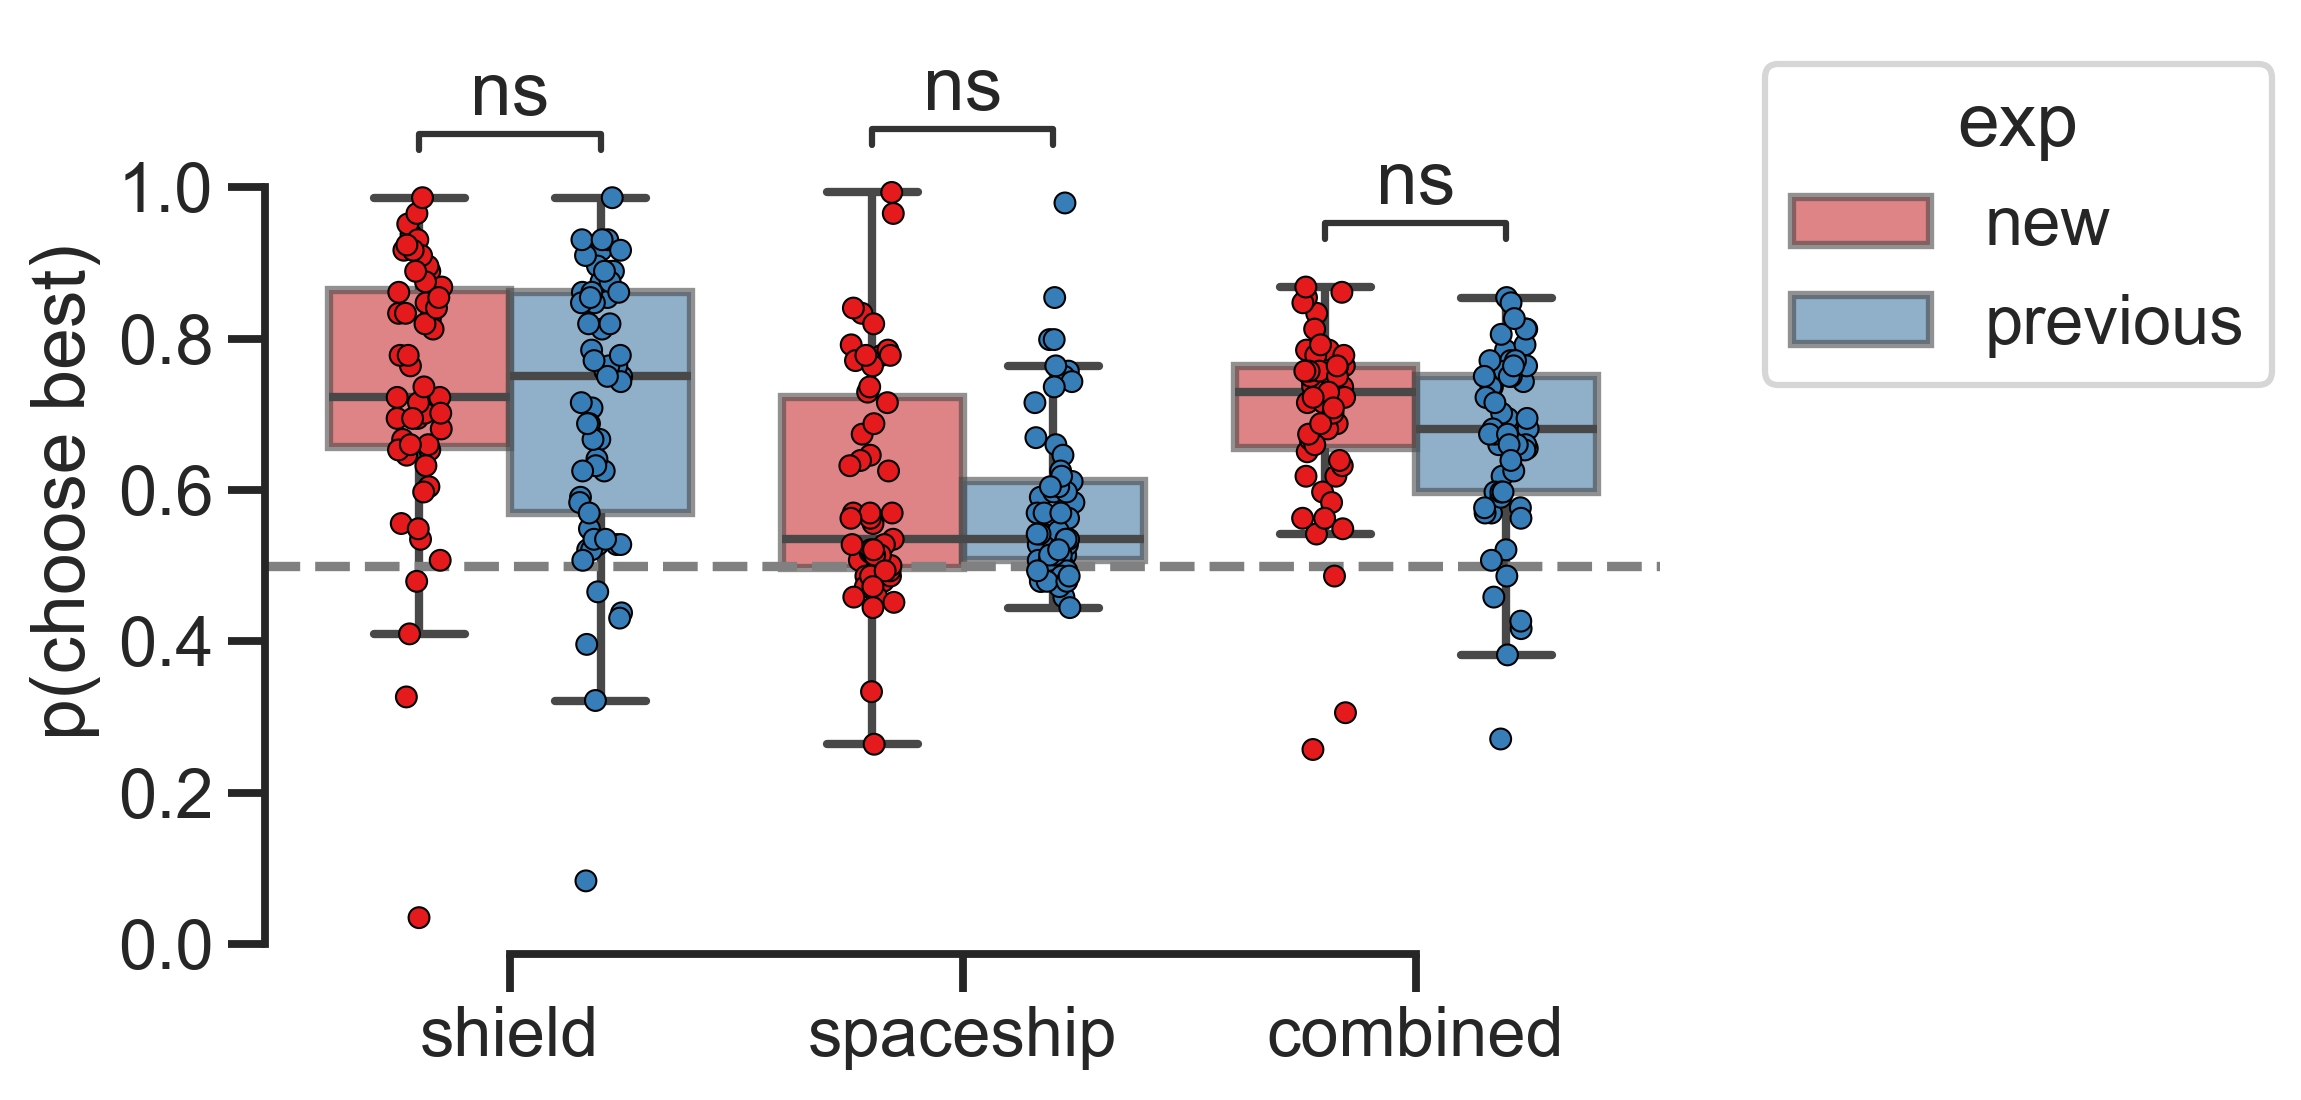

In [138]:
import matplotlib.pyplot as plt
# new df to plot opti_ss and opti_ff side by side
new_df = df[df.expName.isin(['FullPilot12_2', 'FullPilot12'])].melt(id_vars=['expName', 'prolificID','session',  'pair'], value_vars=['opti_ss', 'opti_ff', 'opti_ev'], var_name='type', value_name='opti')
# only keep session 3
# new_df = new_df[new_df.session==3]
new_df = new_df[(new_df.session==3) & (new_df.pair.isin([0, 1]))].groupby(['expName', 'prolificID', 'type']).opti.mean().reset_index()

sns.set(rc={'figure.figsize':(6,4), 'figure.dpi': 300})
sns.set_context("talk")
sns.set_style("ticks")
sns.set_palette('Set1')
order = ['opti_ff', 'opti_ss', 'opti_ev']
hue_order = ['FullPilot12_2', 'FullPilot12']
new_df['type'] = pd.Categorical(new_df['type'], categories=order, ordered=True)
new_df['expName'] = pd.Categorical(new_df['expName'], categories=hue_order, ordered=True)
sns.boxplot(data=new_df, x='type', y='opti', hue='expName', boxprops=dict(alpha=.6), fliersize=0, linewidth=2, order=order)
sns.stripplot(data=new_df, x='type', y='opti', hue='expName', edgecolor='black', jitter=0.1, dodge=True, linewidth=0.5, order=order)
# sns.stripplot(data=new_df, x='type', y='opti', color='gray', alpha=0.3, jitter=0.1)
plt.axhline(0.5, linestyle='--', color='gray')
plt.ylabel('p(choose best)')
plt.xlabel('')
plt.xticks([0, 1, 2], ['shield', 'spaceship', 'combined'])
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(title='exp', bbox_to_anchor=(1.05, 1), loc='upper left', labels=['new', 'previous'], handles=handles[0:2])
sns.despine(trim=True)
from statannotations.Annotator import Annotator
pairs = [(('opti_ff', 'FullPilot12_2'), ('opti_ff', 'FullPilot12')), (('opti_ss', 'FullPilot12'), ('opti_ss', 'FullPilot12_2')),
          (('opti_ev', 'FullPilot12_2'), ('opti_ev', 'FullPilot12'))]
# now compare FullPilot12, FullPilot13, FullPilot14, and FullPilot12_2 on each type
# for t1 in ['opti_ff', 'opti_ss', 'opti_ev']:
#     for i, exp1 in enumerate(['FullPilot12_2', 'FullPilot12', 'FullPilot13', 'FullPilot14']):
#         for exp2 in ['FullPilot12_2', 'FullPilot12', 'FullPilot13', 'FullPilot14'][i+1:]:
#             pairs.append(((t1, exp1), (t1, exp2)))
# put legend outside

new_df['opti'] = new_df['opti'].astype(float)
annot = Annotator(plt.gca(), pairs, data=new_df, x='type', y='opti', hue='expName')
annot.configure(test='t-test_ind', text_format='star', loc='inside', verbose=2)
annot.apply_and_annotate()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

opti_ss_FullPilot13 vs. opti_ss_FullPilot14: Mann-Whitney-Wilcoxon test two-sided, P_val:1.262e-01 U_stat=2.405e+03
opti_ss_FullPilot12 vs. opti_ss_FullPilot12_2: Mann-Whitney-Wilcoxon test two-sided, P_val:8.313e-01 U_stat=1.638e+03
opti_ff_FullPilot13 vs. opti_ff_FullPilot14: Mann-Whitney-Wilcoxon test two-sided, P_val:6.587e-05 U_stat=1.232e+03
opti_ss_FullPilot12 vs. opti_ss_FullPilot12_2: Mann-Whitney-Wilcoxon test two-sided, P_val:8.313e-01 U_stat=1.638e+03
opti_ev_FullPilot12_2 vs. opti_ev_FullPilot13: Mann-Whitney-Wilcoxon test two-sided, P_val:7.756e-02 U_stat=2.092e+03
opti_ev_FullPilot12 vs. opti_ev_FullPilot12_2: Mann-Whitney-Wilcoxon test two-sided, P_val:9.480e-02 U_stat=1.375e+03
opti_ev_FullPilot12 vs. opti_ev_FullPilot12_2: Mann-Whitney-Wilcoxon test two-sided, P_val:9.480e-02 U_s

(<Axes: xlabel='type', ylabel='opti'>,
  <statannotations.Annotation.Annotation at 0x27b8fc90eb0>])

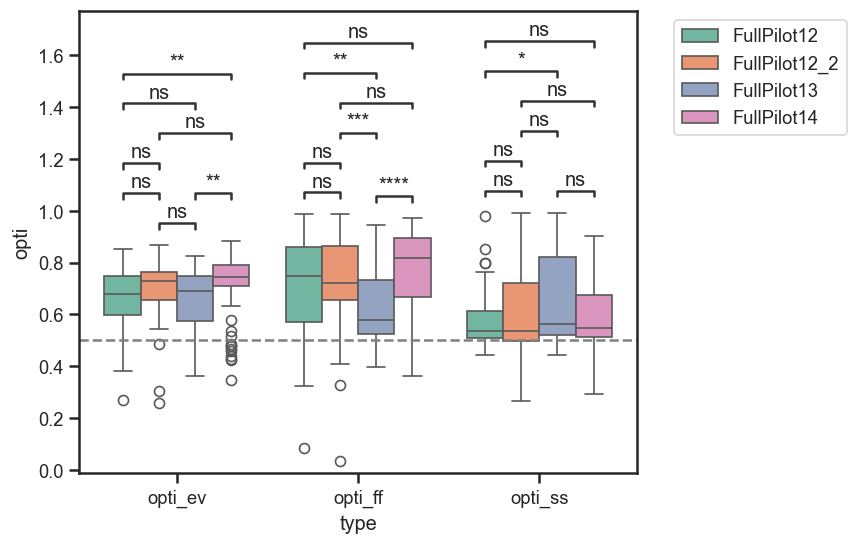

In [ ]:
import matplotlib.pyplot as plt
# new df to plot opti_ss and opti_ff side by side
new_df = df[df.expName.isin(['FullPilot12_2', 'FullPilot12', 'FullPilot13', 'FullPilot14'])].melt(id_vars=['expName', 'prolificID','session',  'pair'], value_vars=['opti_ss', 'opti_ff', 'opti_ev'], var_name='type', value_name='opti')
# only keep session 3
# new_df = new_df[new_df.session==3]
new_df = new_df[(new_df.session==3) & (new_df.pair.isin([0, 1]))].groupby(['expName', 'prolificID', 'type']).opti.mean().reset_index()

sns.boxplot(data=new_df, x='type', y='opti', hue='expName')
# sns.stripplot(data=new_df, x='type', y='opti', color='gray', alpha=0.3, jitter=0.1)
plt.axhline(0.5, linestyle='--', color='gray')

from statannotations.Annotator import Annotator
pairs = [(('opti_ff', 'FullPilot12_2'), ('opti_ff', 'FullPilot12')), (('opti_ss', 'FullPilot12'), ('opti_ss', 'FullPilot12_2')),
          (('opti_ev', 'FullPilot12_2'), ('opti_ev', 'FullPilot12'))]
# now compare FullPilot12, FullPilot13, FullPilot14, and FullPilot12_2 on each type
for t1 in ['opti_ff', 'opti_ss', 'opti_ev']:
    for i, exp1 in enumerate(['FullPilot12_2', 'FullPilot12', 'FullPilot13', 'FullPilot14']):
        for exp2 in ['FullPilot12_2', 'FullPilot12', 'FullPilot13', 'FullPilot14'][i+1:]:
            pairs.append(((t1, exp1), (t1, exp2)))
# put legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
annot = Annotator(plt.gca(), pairs, data=new_df, x='type', y='opti', hue='expName')
annot.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
annot.apply_and_annotate()

session
0     0.67712
1      0.7625
2    0.816667
Name: opti, dtype: object
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: t-test independent samples, P_val:2.406e-02 t=-2.288e+00
1 vs. 2: t-test independent samples, P_val:1.577e-01 t=-1.423e+00
0 vs. 2: t-test independent samples, P_val:5.287e-04 t=-3.573e+00


C:\Users\basil\AppData\Local\Temp\ipykernel_3316\2903269197.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='session', y='opti', data=ddf, showfliers=False, boxprops=dict(alpha=.5),  zorder=-1, linewidth=3, palette=['C1', 'C2', 'C1'], meanline=True)
C:\Users\basil\AppData\Local\Temp\ipykernel_3316\2903269197.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='session', y='opti', data=ddf, alpha=0.9, size=8, zorder=1, edgecolor='black', linewidth=0.5, palette=['C1', 'C2', 'C1'])


(<Axes: ylabel='p(choose best option)'>,
  <statannotations.Annotation.Annotation at 0x185947066a0>])

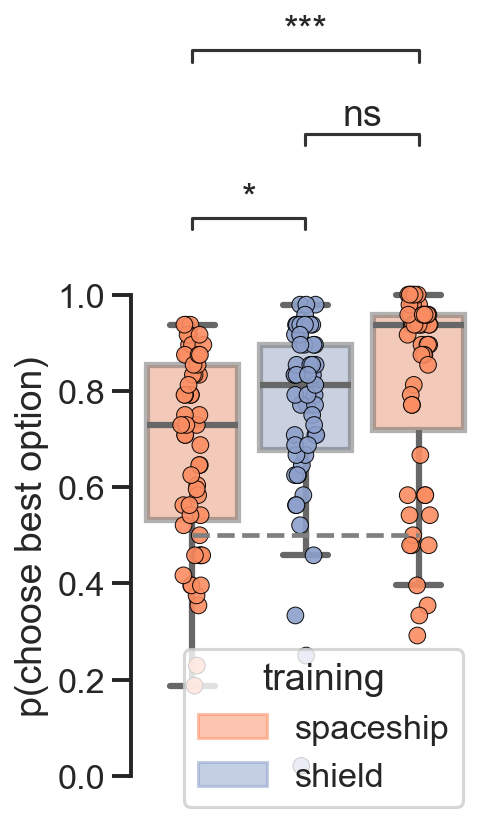

In [9]:
# compare opti_ss mean in session 2 to opti_ff_mean in session 2

sns.set(rc={'figure.figsize':(3, 5), 'figure.dpi':150})
sns.set_style('ticks')
sns.set_context('talk')
sns.set_palette('Set2')
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

ddf = df.copy()
# ddf = ddf[ddf.group!='random']
# ddf = ddf[ddf.t>23] 
ddf = ddf[ddf.session.isin([0,1, 2])]
ddf = ddf[ddf.expName.isin(['FullPilot12_2'])]

# ddf['exp'] = 1
# ddf['opti'] = np.nan
# ddf = ddf[ddf.group!='random']  
# create a new dataframe with id, opti_ss, opti_ff, session
ddf.loc[ddf.session.isin([0,2]), 'opti'] = ddf[ddf.session.isin([0,2])].opti_ss
ddf.loc[ddf.session == 1, 'opti'] = ddf[ddf.session == 1].opti_ff

# session 0 and 2 becomes session 0 with average of opti 0 and 2
# def average_opti(x):
    # for each t and prolificID, return the mean of opti
    # return np.mean(ddf[(ddf.session.isin([0, 2])) & (ddf.prolificID == x.prolificID) & (ddf.t == x.t)].opti)

# ddf['opti'] = ddf.apply(lambda x: average_opti(x) if x.session in [0, 1, 2] else x.opti, axis=1)

# now drop session 2
# ddf = ddf[ddf.session != 2]




ddf = ddf.groupby(['prolificID', 'session'], as_index=False).opti.mean()
# ddf = ddf[ddf.group!='random']
# ddf = ddf[ddf.t>28]
print(ddf.groupby('session').opti.mean())

ax = sns.boxplot(x='session', y='opti', data=ddf, showfliers=False, boxprops=dict(alpha=.5),  zorder=-1, linewidth=3, palette=['C1', 'C2', 'C1'], meanline=True)
# Apply alpha only to the fill (facecolor), keep edge opaque

sns.stripplot(x='session', y='opti', data=ddf, alpha=0.9, size=8, zorder=1, edgecolor='black', linewidth=0.5, palette=['C1', 'C2', 'C1'])

plt.ylabel('p(choose best option)')
plt.plot([0, 2], [0.5, 0.5], color='grey', linestyle='--')
sns.despine(trim=True, bottom=True)
plt.ylim(0, 1)
plt.yticks(np.linspace(0, 1, 6))
plt.xlabel('')
plt.xticks([])
plt.ylim(-.1, 1.1)

# orange is "spaceship training"
# blue is "shield training"
# import patch
import matplotlib.patches as Patch
handles = [
   Patch.Patch(color='C1', label='spaceship', alpha=0.5),
    Patch.Patch(color='C2', label='shield', alpha=0.5),
]

plt.legend(title='training', handles=handles, loc='lower right')

ddf['session'] = ddf['session'].astype(int)
ddf['opti'] = ddf['opti'].astype(float)

from statannotations.Annotator import Annotator
pairs = [ (0, 1), (1, 2), (0, 2)]
annot = Annotator(ax, pairs, data=ddf, x='session', y='opti')
annot.configure(test='t-test_ind', text_format='star', loc='outside', verbose=2)
annot.apply_and_annotate()

In [13]:
ddf['var']

0      ev
1      ff
2      ss
3      ev
4      ff
       ..
178    ff
179    ss
180    ev
181    ff
182    ss
Name: var, Length: 183, dtype: object

var
ev    0.717404
ff    0.677552
ss    0.570347
Name: opti, dtype: object
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ss vs. ff: t-test independent samples, P_val:2.652e-04 t=-3.772e+00
ff vs. ev: t-test independent samples, P_val:1.460e-01 t=-1.465e+00


C:\Users\basil\AppData\Local\Temp\ipykernel_3316\589018895.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(order=order, x='var', y='opti', data=ddf, showfliers=False, boxprops=dict(alpha=.5),  zorder=-1, linewidth=3, palette=['C1', 'C2', 'C0'], meanline=True)
C:\Users\basil\AppData\Local\Temp\ipykernel_3316\589018895.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(order=order, x='var', y='opti', data=ddf, alpha=0.9, size=8, zorder=1, edgecolor='black', linewidth=0.5, palette=['C1', 'C2', 'C0'])


ss vs. ev: t-test independent samples, P_val:2.624e-08 t=-6.004e+00


(<Axes: ylabel='p(choose best)'>,
  <statannotations.Annotation.Annotation at 0x18595684e80>])

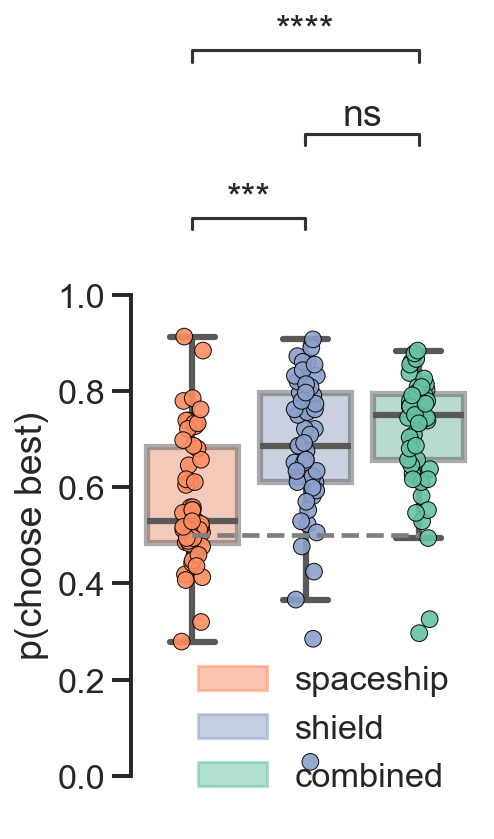

In [31]:
# compare opti_ss mean in session 2 to opti_ff_mean in session 2

sns.set(rc={'figure.figsize':(3, 5), 'figure.dpi':150})
sns.set_style('ticks')
sns.set_context('talk')
sns.set_palette('Set2')
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

ddf = df.copy()
# ddf = ddf[ddf.group!='random']
# ddf = ddf[ddf.t>23] 
ddf = ddf[ddf.session.isin([3])]
ddf = ddf[ddf.expName.isin(['FullPilot12_2'])]

# create a column named var that is either ss, ff, or ev
# the column value is named by opti
# Melt the dataframe to create 'var' and 'opti' columns
df_melted = ddf.melt(
    id_vars=[col for col in ddf.columns if col not in ['opti_ss', 'opti_ff', 'opti_ev']], 
    value_vars=['opti_ss', 'opti_ff', 'opti_ev'],
    var_name='var', 
    value_name='opti'
)

# Clean up the 'var' column to remove 'opti_' prefix
df_melted['var'] = df_melted['var'].str.replace('opti_', '')

# If you want to replace the original df:
# df = df_melted

ddf = df_melted.groupby(['prolificID', 'session', 'var'], as_index=False).opti.mean()

print(ddf.groupby('var').opti.mean())
order = ['ss', 'ff', 'ev']
ax = sns.boxplot(order=order, x='var', y='opti', data=ddf, showfliers=False, boxprops=dict(alpha=.5),  zorder=-1, linewidth=3, palette=['C1', 'C2', 'C0'], meanline=True)
# Apply alpha only to the fill (facecolor), keep edge opaque

sns.stripplot(order=order, x='var', y='opti', data=ddf, alpha=0.9, size=8, zorder=1, edgecolor='black', linewidth=0.5, palette=['C1', 'C2', 'C0'])

plt.ylabel('p(choose best)')
plt.plot([0, 2], [0.5, 0.5], color='grey', linestyle='--')
# sns.despine(trim=True, bottom=True)
plt.ylim(0, 1)
plt.yticks(np.linspace(0, 1, 6))
plt.xlabel('')
plt.xticks([])
plt.ylim(-.1, 1.1)
sns.despine(trim=True, bottom=True)
# orange is "spaceship training"
# blue is "shield training"
# import patch
import matplotlib.patches as Patch
handles = [
   Patch.Patch(color='C1', label='spaceship', alpha=0.5),
    Patch.Patch(color='C2', label='shield', alpha=0.5),
    Patch.Patch(color='C0', label='combined', alpha=0.5)
]

plt.legend(title='', handles=handles, loc='lower right', frameon=False)

ddf['var'] = ddf['var'].astype(str)
ddf['opti'] = ddf['opti'].astype(float)

from statannotations.Annotator import Annotator
pairs = [ ('ss', 'ff'), ('ff', 'ev'), ('ss', 'ev')]
annot = Annotator(ax, pairs, data=ddf, x='var', y='opti',order=order)
annot.configure(test='t-test_ind', text_format='star', loc='outside', verbose=2)
annot.apply_and_annotate()

Data shape after filtering: (8772, 32)
Unique trials: 172
Unique subjects: 51
Reduced from 172 to 34 time points


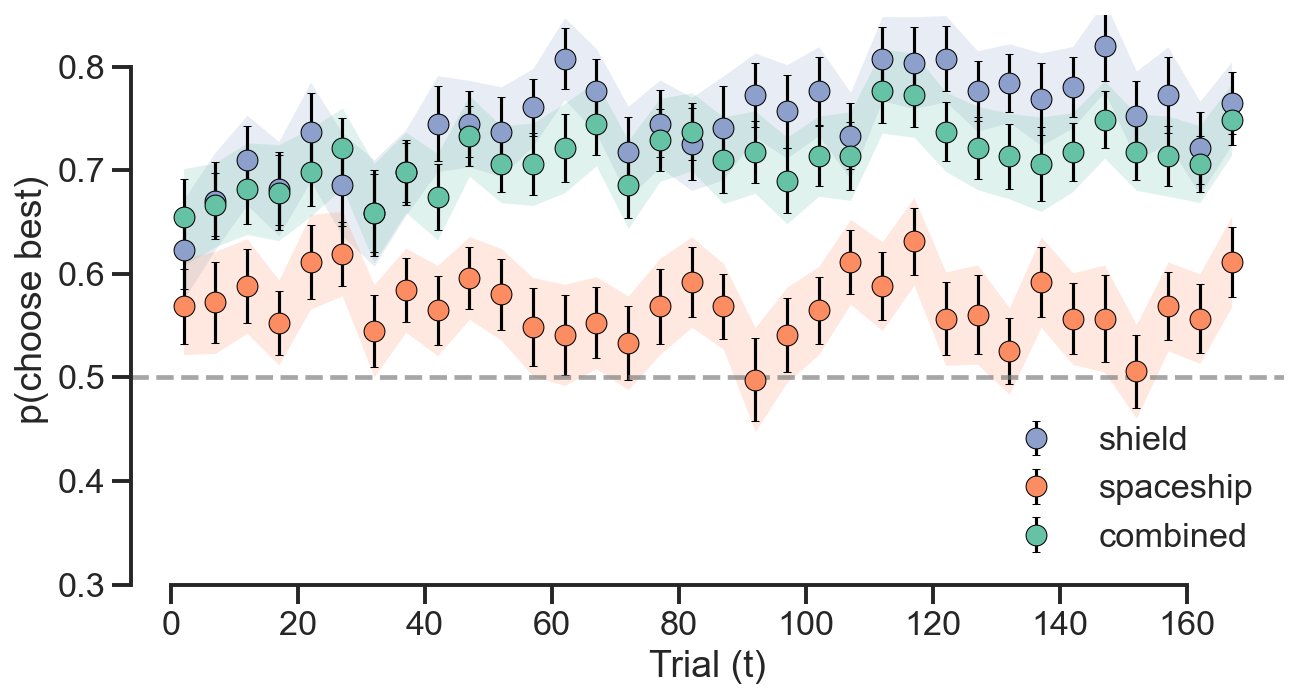


📊 MEAN PERFORMANCE:
Shield (C2): 0.747
Spaceship (C1): 0.567
Combined (C0): 0.712
✅ Plot now shows dots with error bars and reduced data points!


In [18]:
# ========== FINAL PLOT WITH DOTS AND ERROR BARS ==========

# Filter and prepare data using df
data = df[(df.expName=='FullPilot12') & (df.session.isin([3])) & (df.group!='random')].\
groupby(['prolificID', 't'], as_index=False).mean(numeric_only=True)
data = data.sort_values('t').copy()

print(f"Data shape after filtering: {data.shape}")
print(f"Unique trials: {data['t'].nunique()}")
print(f"Unique subjects: {data['prolificID'].nunique()}")

# Create binned data by averaging every 3 trials to reduce from 172 to ~57 points
def bin_trials(data, bin_size=3):
    """Bin trials by averaging every bin_size trials"""
    binned_data = []
    for subject in data['prolificID'].unique():
        subject_data = data[data['prolificID'] == subject].copy()
        subject_data = subject_data.sort_values('t')
        
        # Create bins
        n_trials = len(subject_data)
        n_bins = n_trials // bin_size
        
        for i in range(n_bins):
            start_idx = i * bin_size
            end_idx = min((i + 1) * bin_size, n_trials)
            bin_data = subject_data.iloc[start_idx:end_idx]
            
            # Calculate mean values for this bin
            binned_trial = {
                'prolificID': subject,
                't_bin': i * bin_size + bin_size // 2,  # center of bin
                'opti_ff': bin_data['opti_ff'].mean(),
                'opti_ss': bin_data['opti_ss'].mean(),
                'opti_ev': bin_data['opti_ev'].mean()
            }
            binned_data.append(binned_trial)
    
    return pd.DataFrame(binned_data)

# Create binned dataset
data_binned = bin_trials(data, bin_size=5)
print(f"Reduced from {data['t'].nunique()} to {data_binned['t_bin'].nunique()} time points")

# Calculate means, SEM, and STD for each condition and time bin
def calculate_stats(data, y_col):
    stats = data.groupby('t_bin')[y_col].agg(['mean', 'sem', 'std']).reset_index()
    return stats

stats_ff = calculate_stats(data_binned, 'opti_ff')
stats_ss = calculate_stats(data_binned, 'opti_ss')
stats_ev = calculate_stats(data_binned, 'opti_ev')

# Create the final plot with dots, error bars, and fill
plt.figure(figsize=(9, 5))

# Colors for each condition
colors = {'ff': 'C2', 'ss': 'C1', 'ev': 'C0'}
labels = {'ff': 'shield', 'ss': 'spaceship', 'ev': 'combined'}

# Plot each condition
for stats, condition in [(stats_ff, 'ff'), (stats_ss, 'ss'), (stats_ev, 'ev')]:
    color = colors[condition]
    label = labels[condition]
    
    # Plot dots with SEM error bars and black edges
    plt.errorbar(stats['t_bin'], stats['mean'], yerr=stats['sem'], 
                 fmt='o', color=color, markersize=10, capsize=2, 
                 capthick=1, label=label, linewidth=1.5, 
                 markeredgecolor='black', markeredgewidth=0.5, ecolor='black')
    
    # Add SEM fill with alpha=0.3
    plt.fill_between(stats['t_bin'], 
                     stats['mean'] - stats['sem'] - 0.01, 
                     stats['mean'] + stats['sem'] + 0.01, 
                     color=color, alpha=0.2, linewidth=0)

# Add horizontal reference line
plt.axhline(y=0.5, color='grey', linestyle='--', alpha=0.7)
plt.ylabel('p(choose best)')
plt.xlabel('Trial (t)')

# Set x-axis ticks and y-axis limits
plt.xticks(np.arange(0, 172, 20))
plt.ylim(0.3, 0.85)

# Add a legend
plt.legend(title='', loc='lower right', frameon=False)

# plt.title('Combination phase - Binned by 3 trials')
sns.despine(trim=True)

plt.tight_layout()
plt.show()

# Add mean values at the end for all three conditions
mean_ss = data.groupby(['prolificID'])['opti_ss'].mean().mean()
mean_ff = data.groupby(['prolificID'])['opti_ff'].mean().mean()
mean_ev = data.groupby(['prolificID'])['opti_ev'].mean().mean()

print(f"\n📊 MEAN PERFORMANCE:")
print(f"Shield (C2): {mean_ff:.3f}")
print(f"Spaceship (C1): {mean_ss:.3f}")
print(f"Combined (C0): {mean_ev:.3f}")

print("✅ Plot now shows dots with error bars and reduced data points!")

In [86]:
import matplotlib.pyplot as plt
# new df to plot opti_ss and opti_ff side by side
new_df = df[df.expName.isin(['FullPilot12_2', 'FullPilot12'])].melt(id_vars=['expName', 'prolificID','session',  'pair', 'group'], value_vars=['opti_ss', 'opti_ff', 'opti_ev'], var_name='type', value_name='opti')
# only keep session 3
# new_df = new_df[new_df.session==3]
new_df = new_df[(new_df.session==3) & (new_df.pair.isin([0, 1]))].groupby(['expName', 'prolificID'], as_index=False).group.last().value_counts()

# sns.boxplot(data=new_df, x='type', y='opti', hue='expName')
# # sns.stripplot(data=new_df, x='type', y='opti', color='gray', alpha=0.3, jitter=0.1)
# plt.axhline(0.5, linestyle='--', color='gray')

# from statannotations.Annotator import Annotator
# pairs = [(('opti_ff', 'FullPilot12_2'), ('opti_ff', 'FullPilot12')), (('opti_ss', 'FullPilot12'), ('opti_ss', 'FullPilot12_2')),
#           (('opti_ev', 'FullPilot12_2'), ('opti_ev', 'FullPilot12'))]
# annot = Annotator(plt.gca(), pairs, data=new_df, x='type', y='opti', hue='expName')
# annot.configure(test='t-test_ind', text_format='star', loc='inside', verbose=2)
# annot.apply_and_annotate()

In [88]:
new_df

expName        prolificID                group     
FullPilot12    5484d361fdf99b0379939d5b  combined      1
FullPilot12_2  5e0e1f62814bba56ea1a86dd  perceptual    1
               62877d5f6a054e53313ac916  perceptual    1
               617323e630f3fa36361cb35b  perceptual    1
               616b5241d8eb9504f10a5cb2  combined      1
                                                      ..
FullPilot12    663784abc88d62265def75ea  perceptual    1
               66182d2b06cbee83d298b517  perceptual    1
               660d619f39d061875f78ac8c  random        1
               660c9c26e4220931438f3d30  combined      1
FullPilot12_2  680e7ac23ca1dcd92920d90b  random        1
Name: count, Length: 116, dtype: int64

<Axes: xlabel='delta_p', ylabel='opti'>

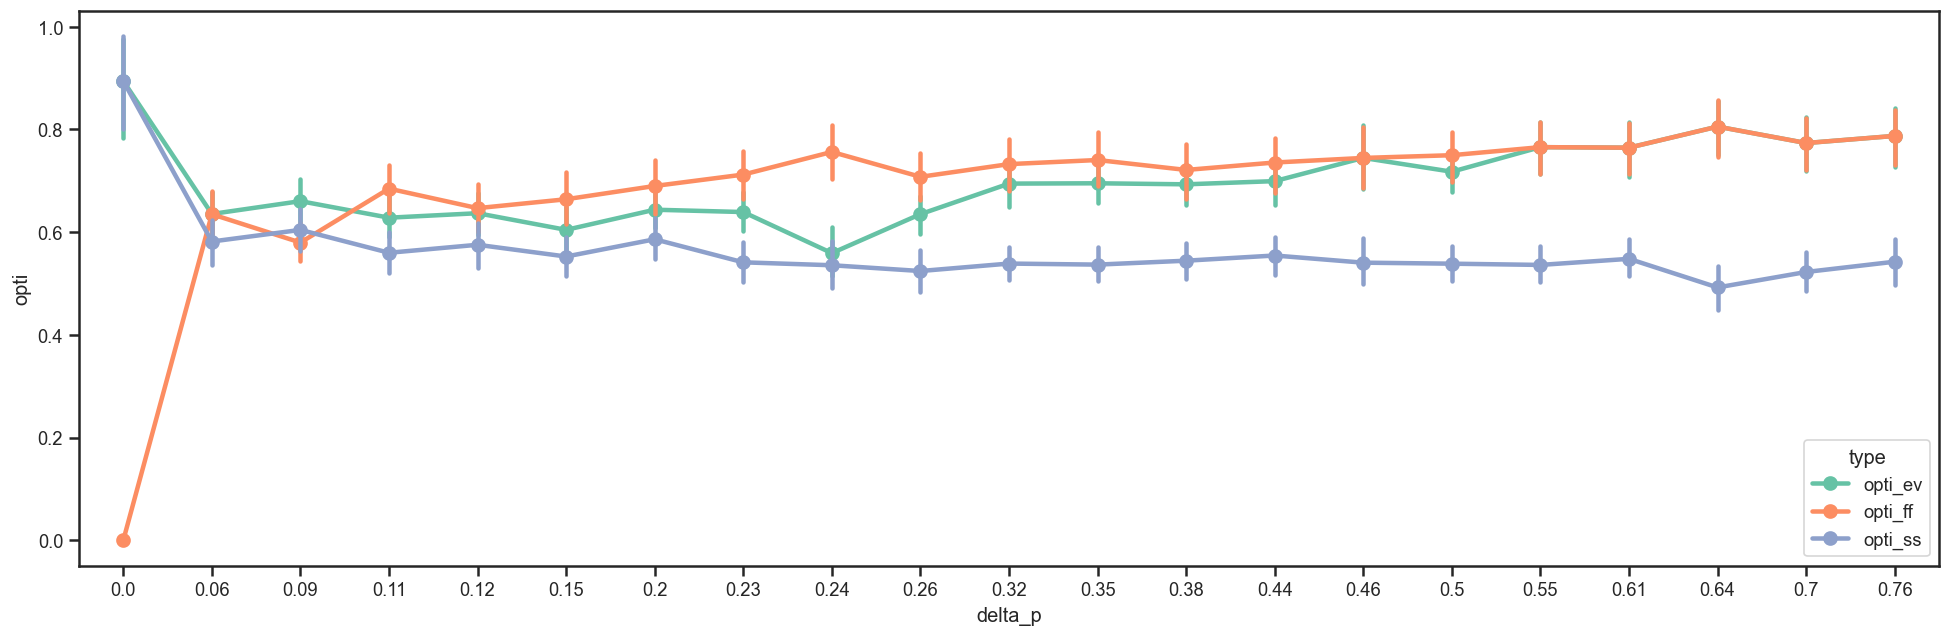

In [64]:
new_df['delta_p'] = round(abs(new_df.p1 - new_df.p2), 4)
new_df = new_df.groupby(['prolificID', 'type', 'delta_p']).opti.mean().reset_index()

plt.figure(figsize=(20, 6))
sns.pointplot(data=new_df, x='delta_p', y='opti', hue='type')


In [59]:
df_

prolificID     type  delta_p      opti
40    5484d361fdf99b0379939d5b  opti_ss     0.06  0.777778
41    5484d361fdf99b0379939d5b  opti_ss     0.09  0.888889
42    5484d361fdf99b0379939d5b  opti_ss     0.11       0.8
43    5484d361fdf99b0379939d5b  opti_ss     0.12       1.0
44    5484d361fdf99b0379939d5b  opti_ss     0.15       0.7
...                        ...      ...      ...       ...
4924  67858bcf2e9aa77b0e98dbb7  opti_ss     0.55  0.444444
4925  67858bcf2e9aa77b0e98dbb7  opti_ss     0.61       0.5
4926  67858bcf2e9aa77b0e98dbb7  opti_ss     0.64       0.4
4927  67858bcf2e9aa77b0e98dbb7  opti_ss     0.70       0.5
4928  67858bcf2e9aa77b0e98dbb7  opti_ss     0.76       0.5

[1643 rows x 4 columns]

AttributeError: 'float' object has no attribute 'shape'

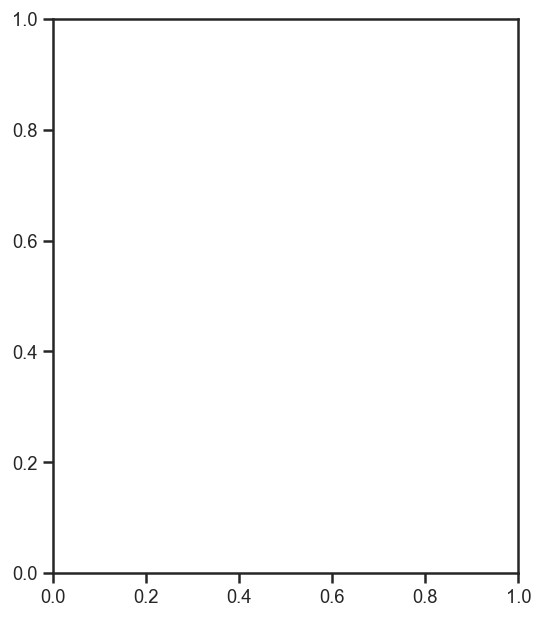

In [75]:
df_ = new_df[new_df.type=='opti_ss'].groupby('delta_p').opti.mean().reset_index()

plt.figure(figsize=(5, 6))
# plot regression line
import scipy.stats as stats
plt.ylim(0, 1)
_= stats.linregress(df_['delta_p'], df_['opti'])
plt.annotate(f'y = {slope:.2f}x + {intercept:.2f}\nr = {r_value:.2f}, p = {p_value:.3f}', xy=(.1, .9), xy=plt.gca().transAxes)
sns.regplot(data=df_, x='delta_p', y='opti')


In [ ]:
a = df[(df.prolificID=='57d02ffb596f5d0001df741f') & (df.session==3) & (df.pair.isin([0, 1]))].chose_risky.mean()
b = df[(df.prolificID=='57d02ffb596f5d0001df741f') & (df.session==3) & (df.pair.isin([0, 1]))].opti_ss.mean()

In [ ]:
a, b

(0.7777777777777778, 0.7777777777777778)

In [ ]:
a = risk[(risk.prolificID=='57d02ffb596f5d0001df741f')].opti_ff
b = risk[(risk.prolificID=='57d02ffb596f5d0001df741f')].chose_risky

In [ ]:
a.values[0] == b.values[0]

False

In [8]:
task_ids = [
    "5c476621b521ee00019abf67",
    "5f1b4845cbf55f3192e33b89",
    "65707ef834f5c6af96da98ce",
    "5d88db42c1d06e001a1fdcab",
    "66c1c5cb4b460dacc8290b9e",
    "5fadeb340e10471fdeb5fbf5",
    "60dfd857e293a99dd577f4c8",
    "62877d5f6a054e53313ac916",
    "66a11a89ba4d8204d085ef26",
    "63d15e1be853005ff591b935",
    "678ff21fa8893f9d40bb501b",
    "662b24af863fd5cc1437384c",
    "5b5a822e1ad8270001c4f28d",
    "5c2ab2de9136140001b90737",
    "67ddf7048bb4a1eb57c71031",
    "607668ac450fc6e3025a131d",
    "672fd24711f758e7a04ac043",
    "67414f166555ae3cdffa2efb",
    "666a595482c8935d66657089",
    "668c0bc95fadbd0e93071351"
]

In [14]:
#compute bonuses

conv = 0.00002
bonuses = []
for prolificID, group in df[(df.session.isin([0,1,2,3,4])) & (df.expName=='FullPilot12_2')].groupby('prolificID'):
    if prolificID not in task_ids:
        continue
    total_points = group.outcome.sum()
    bonus = total_points * conv
    lottery_bonus = lot[lot.prolificID==prolificID].amount.values[0]
    # print(f'ProlificID: {prolificID}, Total Points: {total_points}, Bonus: £{bonus:.2f}, Bonus with lotteries: £{bonus + lottery_bonus:.2f}')
    print(f'{prolificID},{bonus + lottery_bonus:.2f}')
    bonuses.append(bonus+lottery_bonus)

print(f'Average Bonus: £{sum(bonuses) / len(bonuses):.2f}')
print(f'Average Total Bonus with lotteries: £{(sum(bonuses) + lot.amount.sum()) / len(bonuses):.2f}')
print(f'Max Bonus: £{max(bonuses):.2f}, Max Total Bonus with lotteries: £{max(bonuses) + lot.amount.max():.2f}')
# average lot bonus
print(f'Average Lottery Bonus: £{lot.amount.mean():.2f}')

5b5a822e1ad8270001c4f28d,5.82
5c2ab2de9136140001b90737,4.47
5c476621b521ee00019abf67,6.41
5d88db42c1d06e001a1fdcab,6.33
5f1b4845cbf55f3192e33b89,4.64
5fadeb340e10471fdeb5fbf5,5.82
607668ac450fc6e3025a131d,5.04
60dfd857e293a99dd577f4c8,3.93
62877d5f6a054e53313ac916,4.72
63d15e1be853005ff591b935,5.09
65707ef834f5c6af96da98ce,4.82
662b24af863fd5cc1437384c,6.45
666a595482c8935d66657089,4.60
668c0bc95fadbd0e93071351,3.91
66a11a89ba4d8204d085ef26,4.88
66c1c5cb4b460dacc8290b9e,6.52
672fd24711f758e7a04ac043,4.42
67414f166555ae3cdffa2efb,3.66
678ff21fa8893f9d40bb501b,6.17
67ddf7048bb4a1eb57c71031,5.83
Average Bonus: £5.18
Average Total Bonus with lotteries: £9.70
Max Bonus: £6.52, Max Total Bonus with lotteries: £9.06
Average Lottery Bonus: £1.64


In [16]:
np.mean(bonuses) 


5.176878

In [ ]:
def convert_usd_to_gbp_with_inflation(usd_2002_value):
    """
    Converts a USD value from 2002 to its equivalent GBP value in 2025,
    accounting for inflation and exchange rate.
    """
    # --- CPI Data (from BLS) ---
    cpi_2002 = 179.9
    cpi_may_2025 = 321.465 # Latest available CPI for 2025 at time of calculation

    # --- Exchange Rate (approximate as of July 2025) ---
    usd_to_gbp_exchange_rate = 0.73 # 1 USD = 0.73 GBP

    # Step 1: Adjust for inflation (2002 USD to 2025 USD)
    inflation_factor = cpi_may_2025 / cpi_2002
    usd_2025_value = usd_2002_value * inflation_factor

    # Step 2: Convert 2025 USD to 2025 GBP
    gbp_2025_value = usd_2025_value * usd_to_gbp_exchange_rate

    return gbp_2025_value

# Original USD values from the problem
original_usd_values = [2.00, 1.60, 3.85, 0.10]

print("Verifying USD 2002 to GBP 2025 conversion with inflation:")
for usd_val in original_usd_values:
    converted_gbp = convert_usd_to_gbp_with_inflation(usd_val)
    print(f"${usd_val:.2f} (2002 USD) -> £{converted_gbp:.2f} (2025 GBP)")

print("\nThese values should match the 'with inflation' results provided earlier.")

Verifying USD 2002 to GBP 2025 conversion with inflation:
$2.00 (2002 USD) -> £2.61 (2025 GBP)
$1.60 (2002 USD) -> £2.09 (2025 GBP)
$3.85 (2002 USD) -> £5.02 (2025 GBP)
$0.10 (2002 USD) -> £0.13 (2025 GBP)

These values should match the 'with inflation' results provided earlier.


0.2029993192097764


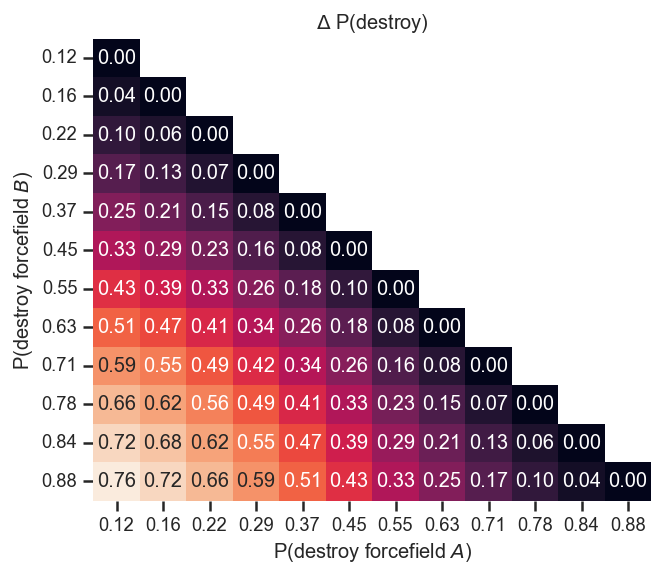

In [ ]:
import itertools
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

values = [0.07692308, 0.15384615, 0.23076923, 0.30769231,
          0.38461538, 0.46153846, 0.53846154, 0.61538462, 0.69230769,
          0.76923077, 0.84615385, 0.92307692]

slope = 2
# logistic function
logistic = lambda x: 1/(1+np.exp(-slope*x))

p = logistic(np.linspace(-1, 1, 12)).round(2)

# Compute all possible deltas as np matrix
all_deltas = np.empty((len(p), len(p)))
for i in range(len(p)):
    for j in range(len(p)):
        all_deltas[i, j] = abs(p[j] - p[i])

# plot deltas in heattmap 
# set x and y using values as labels
# hide half of the heatmap
mask = np.zeros_like(all_deltas)
mask[np.triu_indices_from(mask)] = True
# but keep matrix diagonal
mask[np.diag_indices_from(mask)] = False
sns.heatmap(np.array(all_deltas), cbar=False, xticklabels=p, yticklabels=p, annot=True, fmt='.2f', mask=mask)
# sns.heatmap(np.array(all_deltas), cmap='RdBu_r', cbar=False, xticklabels=p, yticklabels=p, annot=True, fmt='.2f')
# Sort deltas in descending order
# sorted_deltas = sorted(all_deltas, reverse=True)
# print("All Deltas:")
# for delta in all_deltas:
    # print(delta)
# ylabel 45 degree rotation
plt.yticks(rotation=0)
plt.title('$\Delta$ P(destroy)')
plt.xlabel('P(destroy forcefield $A$)')
plt.ylabel('P(destroy forcefield $B$)')
all_deltas = np.array(all_deltas).flatten()
print(np.std((all_deltas)[all_deltas != 0]))


* New pairs (to update)

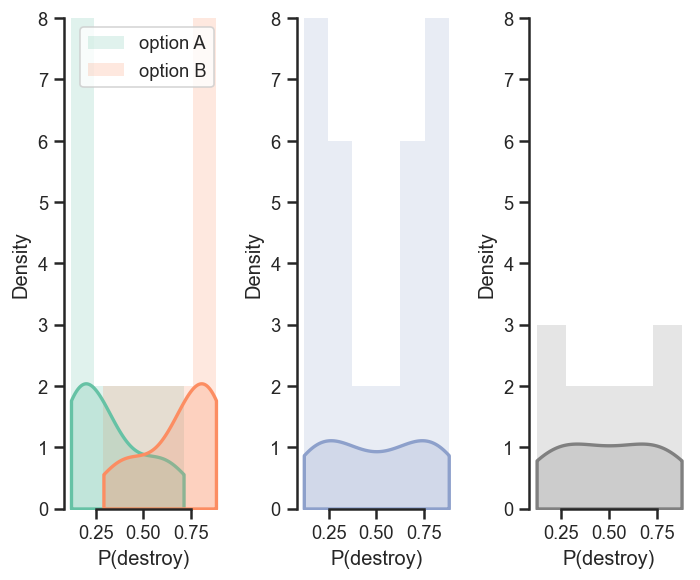

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import src.visualization.plot_settings



x = [(0.16, 0.29),
 (0.71, 0.84),
 (0.22, 0.37),
 (0.63, 0.78),
 (0.55, 0.78),
 (0.22, 0.45),
 (0.37, 0.63),
 (0.55, 0.88),
 (0.12, 0.45),
 (0.29, 0.71),
 (0.16, 0.63),
 (0.37, 0.84),
 (0.12, 0.71),
 (0.29, 0.88),
 (0.16, 0.84),
 (0.12, 0.88)]


x = np.array(x)

# plot hist of x

plt.subplot(1, 3, 1)
sns.histplot(x[:,0],label='option A', color='C0', edgecolor='none', alpha=.2)
sns.histplot(x[:,1], label='option B', color='C1', edgecolor='none', alpha=.2)
sns.kdeplot(x[:,0], color='C0', lw=2, fill=True, alpha=0.25, cut=0)
sns.kdeplot(x[:,1], color='C1', lw=2, fill=True, alpha=0.25, cut=0)
plt.ylabel('Density')
plt.ylim(0, 8)
plt.legend()
sns.despine(trim=True)
plt.xlabel('P(destroy)')

plt.subplot(1, 3, 3)
sns.kdeplot(np.unique(x.flatten()), color='grey', lw=2, fill=True, alpha=0.25, cut=0)
sns.histplot(np.unique(x.flatten()), label='original dist', color='grey', edgecolor='none', alpha=.20)
plt.ylim(0, 8)
sns.despine(trim=True)
plt.xlabel('P(destroy)')

plt.subplot(1, 3, 2)
sns.kdeplot(x.flatten(), color='C2', lw=2, fill=True, alpha=0.25, cut=0)
sns.histplot(x.flatten(), label='pooled', color='C2', edgecolor='none', alpha=.20)
sns.despine(trim=True)
plt.ylim(0, 8)
plt.xlabel('P(destroy)')
plt.tight_layout()

In [ ]:
%pip install matplotlib_venn

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\garciaba\.pyenv\pyenv-win\versions\3.9.12\python.exe -m pip install --upgrade pip' command.


In [ ]:
from ptitprince import PtitPrince as pt
sns.set_style('ticks')
plt.figure(figsize=(8,3), dpi=300)
pt.RainCloud(data=[x[:, 0], x[:, 1], x.flatten(), np.unique(x.flatten())], width_viol=.7, 
             width_box=.1, dodge=True,  bw=.4,  alpha=0.5, linewidth=0, point_size=7, palette=['C0', 'C1', 'C2', 'grey'])
plt.ylim(0, 1)
plt.ylabel('P(destroy)')
plt.xlabel('')
plt.xticks([0, 1, 2, 3], ['paired A', 'paired B', 'paired (pooled)', 'original'])

ModuleNotFoundError: No module named 'ptitprince'